In [83]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, RandomizedSearchCV, GridSearchCV

In [85]:
from imblearn.pipeline import Pipeline, make_pipeline
import imblearn.over_sampling

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1) Read in the dataset

In [88]:
# df = pd.read_csv('Surgical-deepnet.csv')
df = pd.read_csv('SurgeryTiming_full_dataset.csv')
print(df.shape)

df.head()

(32001, 25)


,ahrq_ccs,age,gender,race,asa_status,bmi,baseline_cancer,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,baseline_psych,baseline_pulmonary,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,hour,dow,month,moonphase,mort30,complication
0,<Other>,67.8,1.0,1.0,1.0,28.04,0,1,0,0,1,0,0,0,0,-0.63,-0.26,0.004251,0.072264,9.03,1,11,3,0,0
1,<Other>,39.5,0.0,1.0,1.0,37.85,0,1,0,0,0,0,0,0,0,-0.63,-0.26,0.004251,0.072264,18.48,3,9,1,0,0
2,<Other>,56.5,0.0,1.0,1.0,19.56,0,0,0,0,0,0,0,0,0,-0.49,0.00,0.004251,0.072264,7.88,5,8,3,0,0
3,<Other>,71.0,1.0,1.0,2.0,32.22,0,1,0,0,0,0,0,0,0,-1.38,-1.15,0.004251,0.072264,8.80,3,6,4,0,0
4,<Other>,56.3,1.0,2.0,1.0,24.32,1,0,0,0,0,0,0,0,0,0.00,0.00,0.004251,0.072264,12.20,4,8,4,0,0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32001 entries, 0 to 32000
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ahrq_ccs             32001 non-null  object 
 1   age                  31999 non-null  float64
 2   gender               31998 non-null  float64
 3   race                 31521 non-null  float64
 4   asa_status           31993 non-null  float64
 5   bmi                  28711 non-null  float64
 6   baseline_cancer      32001 non-null  int64  
 7   baseline_cvd         32001 non-null  int64  
 8   baseline_dementia    32001 non-null  int64  
 9   baseline_diabetes    32001 non-null  int64  
 10  baseline_digestive   32001 non-null  int64  
 11  baseline_osteoart    32001 non-null  int64  
 12  baseline_psych       32001 non-null  int64  
 13  baseline_pulmonary   32001 non-null  int64  
 14  baseline_charlson    32001 non-null  int64  
 15  mortality_rsi        32001 non-null 

In [90]:
df['hour'].describe()

count    32001.000000
mean        10.382386
std          2.916799
min          6.000000
25%          7.650000
50%          9.650000
75%         12.720000
max         19.000000
Name: hour, dtype: float64

#### Not sure how we can realistically impute missing values like 'bmi', but plenty of data, so let's just drop NaN rows

In [91]:
df = df[~df.isnull().any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28287 entries, 0 to 32000
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ahrq_ccs             28287 non-null  object 
 1   age                  28287 non-null  float64
 2   gender               28287 non-null  float64
 3   race                 28287 non-null  float64
 4   asa_status           28287 non-null  float64
 5   bmi                  28287 non-null  float64
 6   baseline_cancer      28287 non-null  int64  
 7   baseline_cvd         28287 non-null  int64  
 8   baseline_dementia    28287 non-null  int64  
 9   baseline_diabetes    28287 non-null  int64  
 10  baseline_digestive   28287 non-null  int64  
 11  baseline_osteoart    28287 non-null  int64  
 12  baseline_psych       28287 non-null  int64  
 13  baseline_pulmonary   28287 non-null  int64  
 14  baseline_charlson    28287 non-null  int64  
 15  mortality_rsi        28287 non-null 

### Original study associated w/ the dataset found no statistical significance to time columns in terms of outcomes ('mort30' or 'complication'), so seems reasonable to drop those vars ('hour', 'dow', 'month', 'moonphase')
#### (Original study documented here: https://pubmed.ncbi.nlm.nih.gov/21965365/)

In [92]:
df = df.drop(columns=['hour', 'dow', 'month', 'moonphase'])
df.shape

(28287, 21)

In [93]:
df.describe()

,age,gender,race,asa_status,bmi,baseline_cancer,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,baseline_psych,baseline_pulmonary,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,mort30,complication
count,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000,28287.000000
mean,57.709022,0.459858,1.198749,1.492947,29.467229,0.342702,0.506947,0.007070,0.130979,0.221515,0.180012,0.093612,0.109061,1.177643,-0.538476,-0.425769,0.004328,0.133223,0.004136,0.132393
std,14.917589,0.498395,0.487075,0.560058,7.275193,0.474621,0.499961,0.083789,0.337383,0.415274,0.384204,0.291293,0.311721,1.856691,1.033264,1.186305,0.004660,0.088045,0.064181,0.338923
min,1.000000,0.000000,1.000000,1.000000,2.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.400000,-4.720000,0.000000,0.016118,0.000000,0.000000
25%,48.300000,0.000000,1.000000,1.000000,24.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.240000,-0.860000,0.000789,0.081977,0.000000,0.000000
50%,58.600000,0.000000,1.000000,1.000000,28.200000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.300000,-0.310000,0.002764,0.109369,0.000000,0.000000
75%,68.300000,1.000000,1.000000,2.000000,32.840000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.007398,0.183370,0.000000,0.000000
max,90.000000,1.000000,3.000000,3.000000,92.590000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,4.830000,12.560000,0.016673,0.466129,1.000000,1.000000


### Variables to One-Hot Encode:
#### 'race', 'ahrq_ccs'
#### NOTE: Not one-hot encoding asa_status, since it should have ordinality (reflects extent of anathesiological intervention)

In [94]:
df['race'].value_counts()

1.0    23768
2.0     3416
3.0     1103
Name: race, dtype: int64

In [95]:
df['ahrq_ccs'].nunique()

23

In [96]:
df['ahrq_ccs'].unique()

array(['<Other>', 'Arthroplasty knee', 'Colorectal resection',
       'Endoscopy and endoscopic biopsy of the urinary tract',
       'Gastrectomy; partial and total',
       'Genitourinary incontinence procedures',
       'Hip replacement; total and partial',
       'Hysterectomy; abdominal and vaginal',
       'Inguinal and femoral hernia repair',
       'Laminectomy; excision intervertebral disc',
       'Lumpectomy; quadrantectomy of breast', 'Mastectomy',
       'Nephrectomy; partial or complete',
       'Oophorectomy; unilateral and bilateral', 'Open prostatectomy',
       'Other excision of cervix and uterus', 'Other hernia repair',
       'Plastic procedures on nose',
       'Repair of cystocele and rectocele; obliteration of vaginal vault',
       'Small bowel resection', 'Spinal fusion',
       'Thyroidectomy; partial or complete',
       'Transurethral resection of prostate (TURP)'], dtype=object)

#### NOTE: Deliberately not dropping first column since Tree Models need it; must remember to drop it w/ Logistic Regression models!

In [97]:
df = pd.get_dummies(df, columns=['race', 'ahrq_ccs'], drop_first=False)

In [98]:
print(df.shape)
df.head()

(28287, 45)


,age,gender,asa_status,bmi,baseline_cancer,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,baseline_psych,baseline_pulmonary,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,mort30,complication,race_1.0,race_2.0,race_3.0,ahrq_ccs_<Other>,ahrq_ccs_Arthroplasty knee,ahrq_ccs_Colorectal resection,ahrq_ccs_Endoscopy and endoscopic biopsy of the urinary tract,ahrq_ccs_Gastrectomy; partial and total,ahrq_ccs_Genitourinary incontinence procedures,ahrq_ccs_Hip replacement; total and partial,ahrq_ccs_Hysterectomy; abdominal and vaginal,ahrq_ccs_Inguinal and femoral hernia repair,ahrq_ccs_Laminectomy; excision intervertebral disc,ahrq_ccs_Lumpectomy; quadrantectomy of breast,ahrq_ccs_Mastectomy,ahrq_ccs_Nephrectomy; partial or complete,ahrq_ccs_Oophorectomy; unilateral and bilateral,ahrq_ccs_Open prostatectomy,ahrq_ccs_Other excision of cervix and uterus,ahrq_ccs_Other hernia repair,ahrq_ccs_Plastic procedures on nose,ahrq_ccs_Repair of cystocele and rectocele; obliteration of vaginal vault,ahrq_ccs_Small bowel resection,ahrq_ccs_Spinal fusion,ahrq_ccs_Thyroidectomy; partial or complete,ahrq_ccs_Transurethral resection of prostate (TURP)
0,67.8,1.0,1.0,28.04,0,1,0,0,1,0,0,0,0,-0.63,-0.26,0.004251,0.072264,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,39.5,0.0,1.0,37.85,0,1,0,0,0,0,0,0,0,-0.63,-0.26,0.004251,0.072264,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56.5,0.0,1.0,19.56,0,0,0,0,0,0,0,0,0,-0.49,0.00,0.004251,0.072264,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,71.0,1.0,2.0,32.22,0,1,0,0,0,0,0,0,0,-1.38,-1.15,0.004251,0.072264,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,56.3,1.0,1.0,24.32,1,0,0,0,0,0,0,0,0,0.00,0.00,0.004251,0.072264,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### IMPORTANT NOTE: For Logistic Regression models, need to drop columns 'race_1.0' and 'ahrq_ccs_<Other\>'

#### Two potential targets: 'mort30' (mortality in the 30 days post-surgery) and 'complication' (in-hospital complication)

In [99]:
print('mort30 Percentage: {}'.format(100*round(df[df['mort30'] == 1].shape[0]/df.shape[0], 5)))

mort30 Percentage: 0.414


In [100]:
print('complication Percentage: {}'.format(100*round(df[df['complication']==1].shape[0]/df.shape[0], 3)))

complication Percentage: 13.200000000000001


#### Does 'mort30' always count as a 'complication'? No!

In [101]:
100*round(df[(df['mort30'] == 1) & (df['complication'] == 1)].shape[0]/df.shape[0], 5)

0.134

## 2) Split the data into train/val/test (using stratification)

In [102]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['mort30', 'complication']])

In [103]:
train, val = train_test_split(train, test_size=0.25, random_state=42, stratify=train[['mort30', 'complication']])

#### Check to see if percentages were retained

In [104]:
print('mort30 Train Percentage: {}'
      .format(100*round(train[train['mort30'] == 1].shape[0]/train.shape[0], 5)))
print('mort30 Val Percentage: {}'
      .format(100*round(val[val['mort30'] == 1].shape[0]/val.shape[0], 5)))
print('mort30 Test Percentage: {}'
      .format(100*round(test[test['mort30'] == 1].shape[0]/test.shape[0], 5)))
print('complication Train Percentage: {}'
      .format(100*round(train[train['complication']==1].shape[0]/train.shape[0], 3)))
print('complication Val Percentage: {}'
      .format(100*round(val[val['complication']==1].shape[0]/val.shape[0], 3)))
print('complication Test Percentage: {}'
      .format(100*round(test[test['complication']==1].shape[0]/test.shape[0], 3)))

mort30 Train Percentage: 0.41200000000000003
mort30 Val Percentage: 0.407
mort30 Test Percentage: 0.424
complication Train Percentage: 13.200000000000001
complication Val Percentage: 13.200000000000001
complication Test Percentage: 13.200000000000001


#### Good enough (tough to get 'mort30' percentages perfect due to small number of positive examples)

In [105]:
X_train = train.drop(columns=['mort30', 'complication', 'race_1.0', 'ahrq_ccs_<Other>'])
y_train = train[['mort30', 'complication']]

X_val = val.drop(columns=['mort30', 'complication', 'race_1.0', 'ahrq_ccs_<Other>'])
y_val = val[['mort30', 'complication']]

X_test = test.drop(columns=['mort30', 'complication', 'race_1.0', 'ahrq_ccs_<Other>'])
y_test = test[['mort30', 'complication']]

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (16971, 41)
y_train shape: (16971, 2)
X_val shape: (5658, 41)
y_val shape: (5658, 2)
X_test shape: (5658, 41)
y_test shape: (5658, 2)


## 3) Baseline model for 'mort30' target (Logistic Regression, no regularization)

In [106]:
def auc_proba_scorer(model, X, y):
    y_pred = model.predict_proba(X)[:,1]
    return roc_auc_score(y, y_pred)

In [107]:
def cv_aurocs(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring=auc_proba_scorer, cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('\nCV AUROCs: {}'.format(scores)) 
    print('Mean CV AUROC: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))

In [108]:
def plot_prec_recall(y_1, y_1_pred, y_2=None, y_2_pred=None, single_title=None, single=False):
    precisions1, recalls1, threshs1 = precision_recall_curve(y_1, y_1_pred )
    if single:
        N = 1
    else:
        N = 2
        precisions2, recalls2, threshs2 = precision_recall_curve(y_2, y_2_pred )
    
    plt.figure(figsize=(8*N,10), dpi=80)
    plt.subplot(2, N, 1)
    plt.plot(threshs1, precisions1[1:], label='Precision', lw=3)
    plt.plot(threshs1, recalls1[1:], label='Recall', lw=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.grid(b=True)
    plt.legend(prop={"size":12})
    plt.xlabel('Threshold', size=13)
    if single_title == None:
        plt.title('Training Set', size=20)
    else:
        plt.title(single_title, size=20)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    if N == 2:
        plt.subplot(2, N, 2)
        plt.plot(threshs2, precisions2[1:], label='Precision', lw=3)
        plt.plot(threshs2, recalls2[1:], label='Recall', lw=3)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xticks(np.linspace(0,1,11))
        plt.yticks(np.linspace(0,1,11))
        plt.grid(b=True)
        plt.legend(prop={"size":12})
        plt.xlabel('Threshold', size=13)
        plt.title('Validation Set', size=20)
        plt.xticks(size=12)
        plt.yticks(size=12)
    
    plt.subplot(2, N, N+1)
    plt.plot(recalls1[1:], precisions1[1:], lw=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.grid(b=True)
    plt.xlabel("Recall", size=16)
    plt.ylabel("Precision", size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    if N == 2:
        plt.subplot(2, N, 4)
        plt.plot(recalls2[1:], precisions2[1:], lw=3)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xticks(np.linspace(0,1,11))
        plt.yticks(np.linspace(0,1,11))
        plt.grid(b=True)
        plt.xlabel("Recall", size=16)
        plt.ylabel("Precision", size=16)
        plt.xticks(size=12)
        plt.yticks(size=12);

In [109]:
def plot_aurocs(y_1, y_1_pred, y_2=None, y_2_pred=None, single_title=None, single=False):
    fpr1, tpr1, thresholds1 = roc_curve(y_1, y_1_pred)
    roc_auc1 = roc_auc_score(y_1, y_1_pred)
    if not single:
        fpr2, tpr2, thresholds2 = roc_curve(y_2, y_2_pred)
        roc_auc2 = roc_auc_score(y_2, y_2_pred)
    
    plt.figure(figsize=(10,10), dpi=80)
    if single_title != None:
        plt.plot(fpr1, tpr1, lw=3, label=single_title + '(AUC = %0.3f)' % roc_auc1)
    else:
        plt.plot(fpr1, tpr1, lw=3, label='Training Set (AUC = %0.3f)' % roc_auc1)
    if not single:
        plt.plot(fpr2, tpr2, lw=3, label='Validation Set (AUC = %0.3f)' % roc_auc2)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.grid(b=True)
    plt.title('AUROC', size=20)
    plt.legend(prop={"size":12})
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.xticks(size=12)
    plt.yticks(size=12);

In [110]:
lr_mort = LogisticRegression(penalty='none', max_iter=10000)

cv_aurocs(X_train, y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.838, 0.873, 0.976, 0.898, 0.823]
Mean CV AUROC: 0.882 +/- 0.054


Training Set AUROC: 0.9489260990473937
Validation Set AUROC: 0.9398325681879557






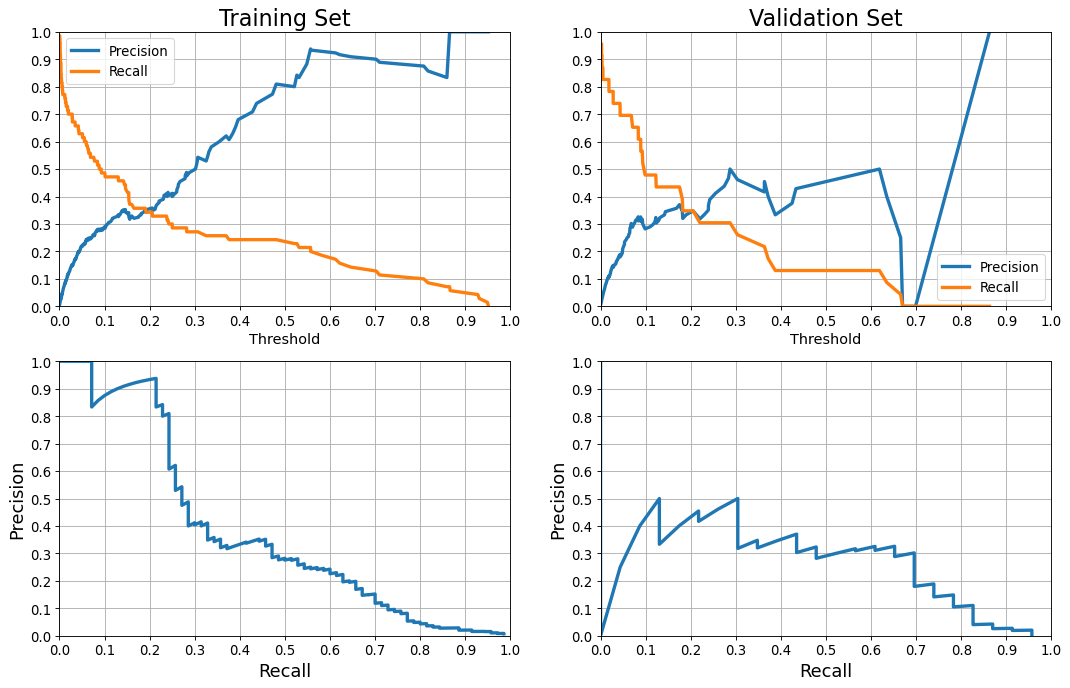

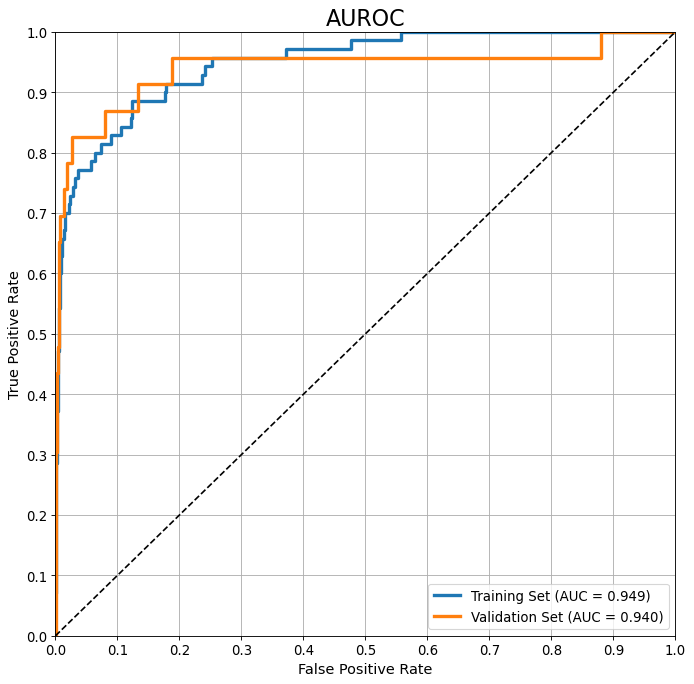

In [111]:
lr_mort.fit(X_train, y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train)[:,1]
y_val_pred = lr_mort.predict_proba(X_val)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

#### Already a pretty high AUROC and not looking overfit! (May not even need regularization)

## 4) Now for some further EDA and Feature Engineering

### Start w/ 'mort30' as the target:

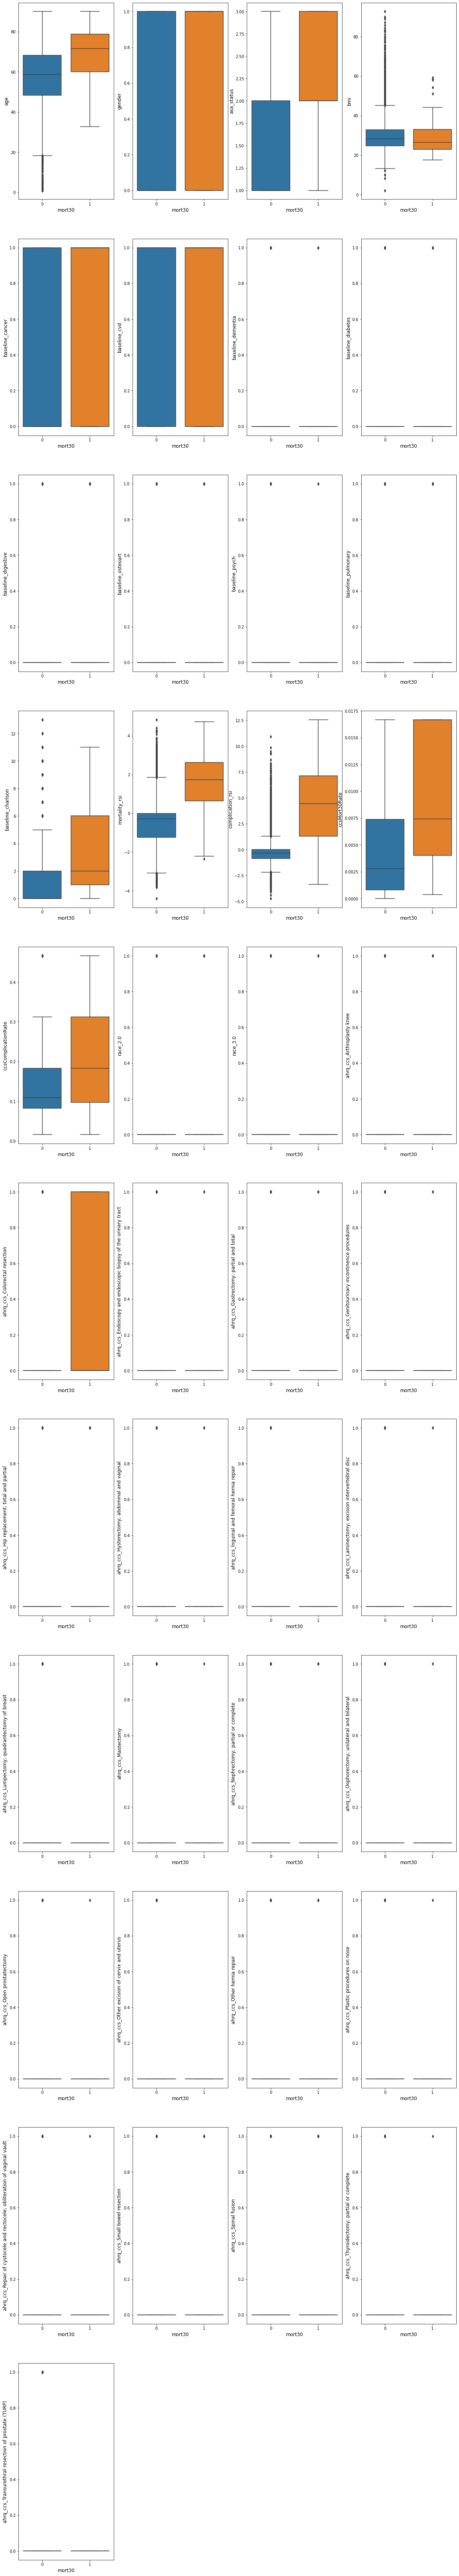

In [112]:
sns.color_palette('colorblind')
plt.figure(figsize=(20,120))
xlabel='mort30'
rows = 11 
cols = 4
for n, column in enumerate(df.drop(columns=['mort30', 'complication', 'race_1.0', 'ahrq_ccs_<Other>']).columns):
    plt.subplot(rows, cols, n+1)
    sns.boxplot(x=xlabel, y=column, data = df)
    plt.xlabel('mort30', size=12)
    plt.ylabel(column, size=12);

#### Based on the results above, let's try a quick Logistic Regression just on the most separable variables:

In [113]:
lr_mort = LogisticRegression(penalty='none', max_iter=10000)

cv_aurocs(X_train[['age', 'asa_status', 'baseline_charlson', 'mortality_rsi', 'complication_rsi', 
                   'ccsMort30Rate', 'ccsComplicationRate', 'ahrq_ccs_Colorectal resection']], 
          y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.893, 0.898, 0.983, 0.909, 0.864]
Mean CV AUROC: 0.909 +/- 0.04


Training Set AUROC: 0.9218558496116037
Validation Set AUROC: 0.9450561320936692






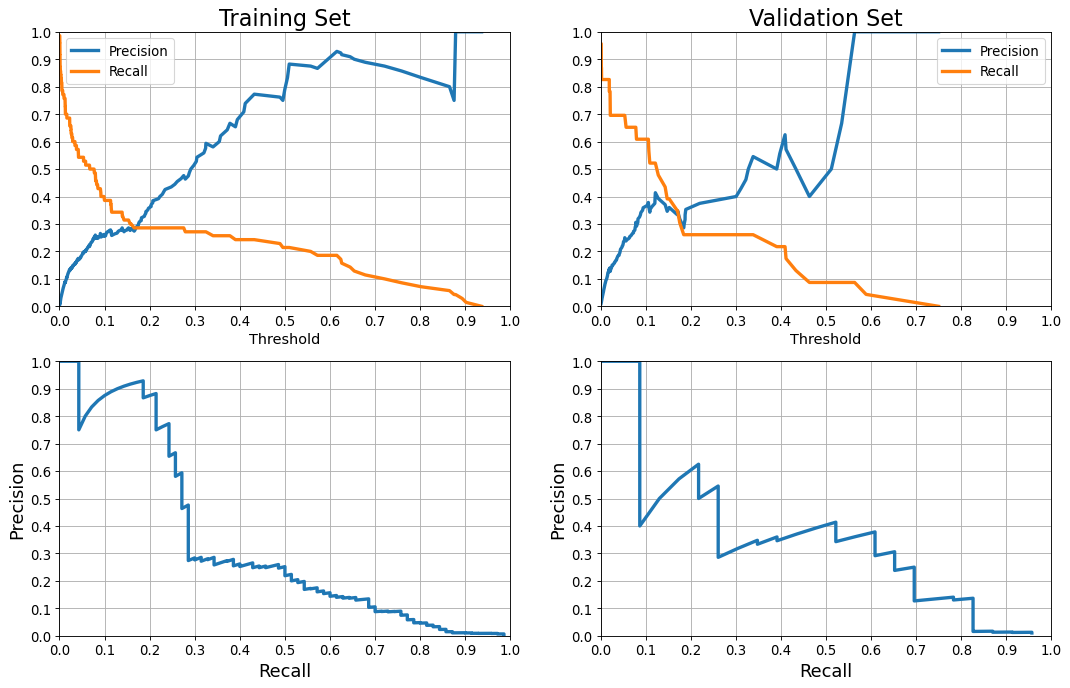

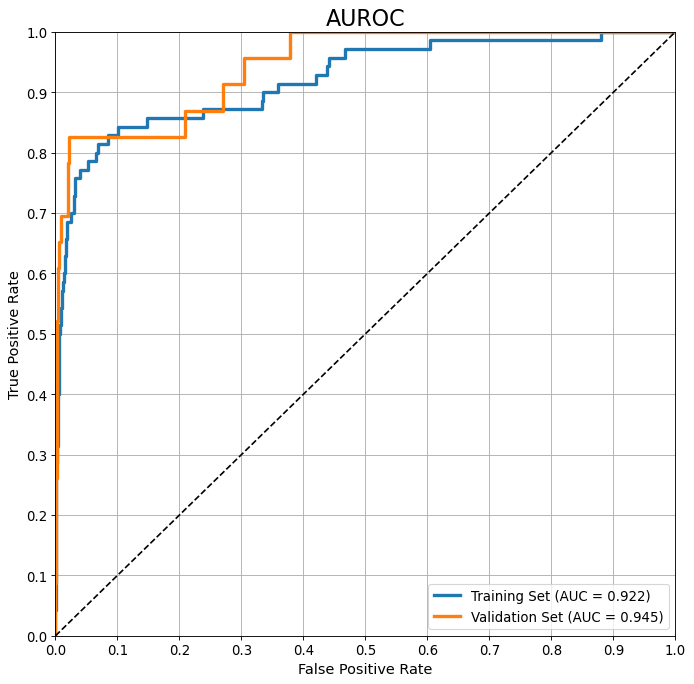

In [114]:
lr_mort.fit(X_train[['age', 'asa_status', 'baseline_charlson', 'mortality_rsi', 'complication_rsi', 
                      'ccsMort30Rate', 'ccsComplicationRate', 'ahrq_ccs_Colorectal resection']], 
             y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train[['age', 'asa_status', 'baseline_charlson', 'mortality_rsi', 
                                              'complication_rsi', 'ccsMort30Rate', 'ccsComplicationRate', 
                                              'ahrq_ccs_Colorectal resection']])[:,1]

y_val_pred = lr_mort.predict_proba(X_val[['age', 'asa_status', 'baseline_charlson', 'mortality_rsi', 
                                          'complication_rsi', 'ccsMort30Rate', 'ccsComplicationRate', 
                                          'ahrq_ccs_Colorectal resection']])[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

#### Slightly less well-fit, it seems to me (although recall is definitely better)

#### What if we drop all but the most obviously separable of the variables?

In [115]:
lr_mort = LogisticRegression(penalty='none', max_iter=10000)

cv_aurocs(X_train[['asa_status', 'mortality_rsi', 'complication_rsi', 
                   'ahrq_ccs_Colorectal resection']], 
          y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.887, 0.918, 0.985, 0.896, 0.859]
Mean CV AUROC: 0.909 +/- 0.042


Training Set AUROC: 0.916913200402343
Validation Set AUROC: 0.9258709154739402






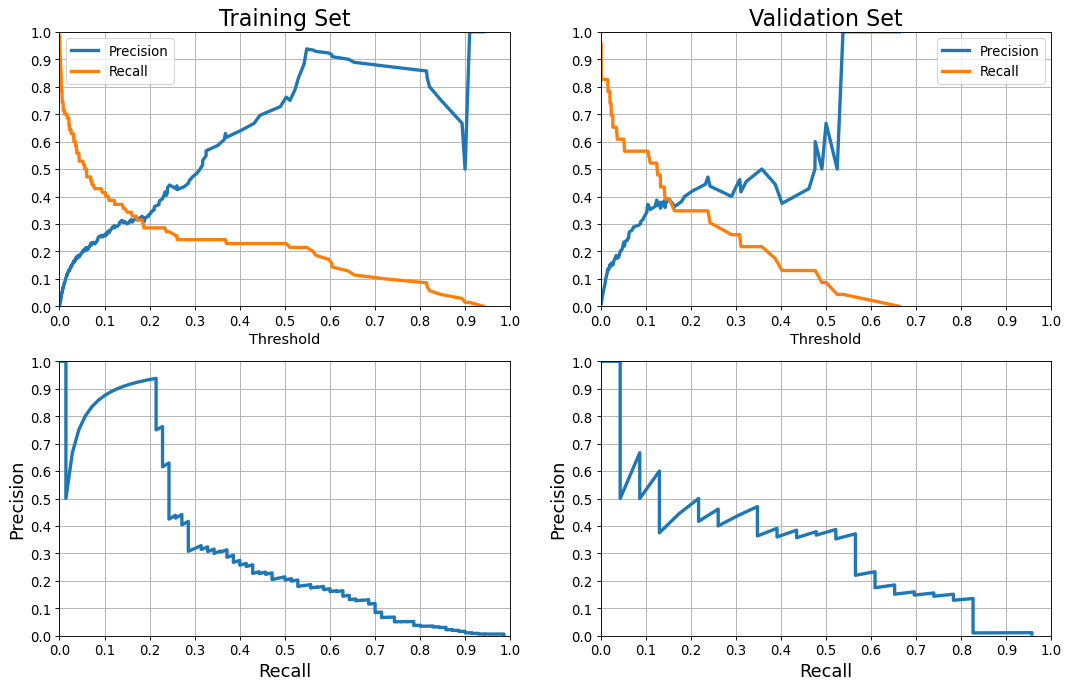

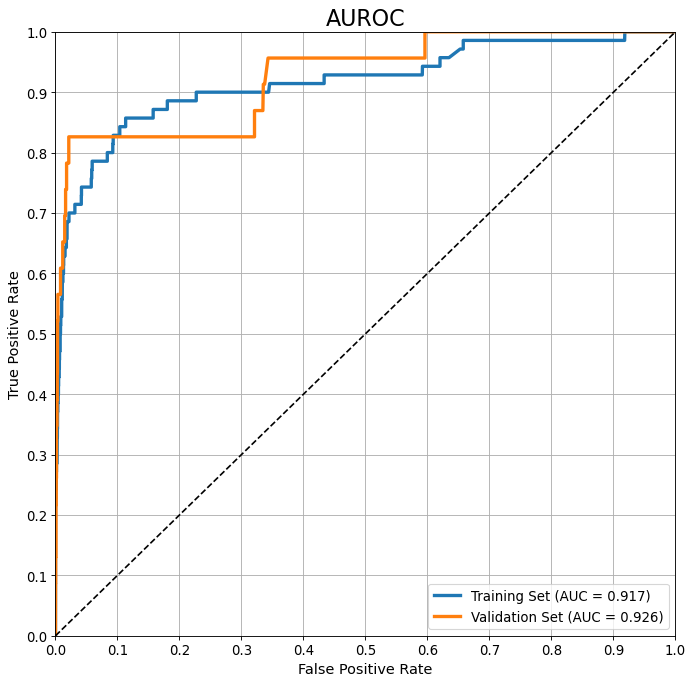

In [116]:
lr_mort.fit(X_train[['asa_status', 'mortality_rsi', 'complication_rsi', 
                     'ahrq_ccs_Colorectal resection']],
             y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train[['asa_status', 'mortality_rsi', 'complication_rsi', 
                                              'ahrq_ccs_Colorectal resection']])[:,1]

y_val_pred = lr_mort.predict_proba(X_val[['asa_status', 'mortality_rsi', 'complication_rsi', 
                                          'ahrq_ccs_Colorectal resection']])[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

#### Similar to last model - let's stop dropping variables and head in the other direction (more variables)!

### Engineer Features using the non-binary predictors

In [117]:
X_train_reduced = X_train[['age', 'asa_status', 'bmi', 'baseline_charlson', 'mortality_rsi', 
                           'complication_rsi', 'ccsMort30Rate', 'ccsComplicationRate']]
X_train_reduced.describe()

,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate
count,16971.000000,16971.000000,16971.000000,16971.000000,16971.000000,16971.000000,16971.000000,16971.000000
mean,57.644629,1.492782,29.452362,1.178834,-0.535384,-0.423963,0.004266,0.132740
std,14.896823,0.560214,7.259499,1.860837,1.039436,1.192643,0.004615,0.087723
min,1.000000,1.000000,2.150000,0.000000,-4.400000,-4.720000,0.000000,0.016118
25%,48.300000,1.000000,24.610000,0.000000,-1.240000,-0.860000,0.000789,0.081977
50%,58.500000,1.000000,28.190000,0.000000,-0.300000,-0.300000,0.002764,0.109369
75%,68.200000,2.000000,32.800000,2.000000,0.000000,0.000000,0.007398,0.183370
max,90.000000,3.000000,89.930000,13.000000,4.830000,12.560000,0.016673,0.466129


In [118]:
X_val_reduced = X_val[['age', 'asa_status', 'bmi', 'baseline_charlson', 'mortality_rsi', 
                       'complication_rsi', 'ccsMort30Rate', 'ccsComplicationRate']]

X_test_reduced = X_test[['age', 'asa_status', 'bmi', 'baseline_charlson', 'mortality_rsi', 
                         'complication_rsi', 'ccsMort30Rate', 'ccsComplicationRate']]

In [119]:
def calc_all(x):
    return np.exp(1)**x, np.log10(x), x**2, x**3

X_train_reduced['age_exp'], X_train_reduced['age_log'], \
            X_train_reduced['age_sq'], X_train_reduced['age_cube'] = zip(*X_train['age'].map(calc_all))
X_train_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3264816971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['age_exp'], X_train_reduced['age_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3264816971.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['age_sq'], X_train_reduced['age_cube'] = zip(*X_train['age'].map(calc_all))


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube
29384,74.8,2.0,31.73,0,-0.45,-1.35,0.007424,0.183370,3.056520e+32,1.873902,5595.04,418508.992
9519,35.1,1.0,22.56,6,3.65,2.91,0.007398,0.097476,1.752816e+15,1.545307,1232.01,43243.551
9928,78.9,2.0,20.62,1,-0.20,0.26,0.007398,0.097476,1.844313e+34,1.897077,6225.21,491169.069
22483,68.1,2.0,32.16,3,-0.86,-0.76,0.000373,0.109369,3.762307e+29,1.833147,4637.61,315821.241
29900,64.3,1.0,25.45,2,0.00,0.00,0.000672,0.016118,8.416571e+27,1.808211,4134.49,265847.707


In [120]:
X_val_reduced['age_exp'], X_val_reduced['age_log'], \
            X_val_reduced['age_sq'], X_val_reduced['age_cube'] = zip(*X_val['age'].map(calc_all))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/846485104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['age_exp'], X_val_reduced['age_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/846485104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['age_sq'], X_val_reduced['age_cube'] = zip(*X_val['age'].map(calc_all))


In [121]:
X_test_reduced['age_exp'], X_test_reduced['age_log'], \
            X_test_reduced['age_sq'], X_test_reduced['age_cube'] = zip(*X_test['age'].map(calc_all))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1720322886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['age_exp'], X_test_reduced['age_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1720322886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['age_sq'], X_test_reduced['age_cube'] = zip(*X_test['age'].map(calc_all))


In [122]:
X_train_reduced['asa_status_exp'], X_train_reduced['asa_status_log'], \
            X_train_reduced['asa_status_sq'], X_train_reduced['asa_status_cube'] = \
            zip(*X_train['asa_status'].map(calc_all))
X_train_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1599482520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['asa_status_exp'], X_train_reduced['asa_status_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1599482520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['asa_status_sq'], X_train_reduced['asa_status_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube
29384,74.8,2.0,31.73,0,-0.45,-1.35,0.007424,0.183370,3.056520e+32,1.873902,5595.04,418508.992,7.389056,0.30103,4.0,8.0
9519,35.1,1.0,22.56,6,3.65,2.91,0.007398,0.097476,1.752816e+15,1.545307,1232.01,43243.551,2.718282,0.00000,1.0,1.0
9928,78.9,2.0,20.62,1,-0.20,0.26,0.007398,0.097476,1.844313e+34,1.897077,6225.21,491169.069,7.389056,0.30103,4.0,8.0
22483,68.1,2.0,32.16,3,-0.86,-0.76,0.000373,0.109369,3.762307e+29,1.833147,4637.61,315821.241,7.389056,0.30103,4.0,8.0
29900,64.3,1.0,25.45,2,0.00,0.00,0.000672,0.016118,8.416571e+27,1.808211,4134.49,265847.707,2.718282,0.00000,1.0,1.0


In [123]:
X_val_reduced['asa_status_exp'], X_val_reduced['asa_status_log'], \
            X_val_reduced['asa_status_sq'], X_val_reduced['asa_status_cube'] = \
            zip(*X_val['asa_status'].map(calc_all))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3890627599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['asa_status_exp'], X_val_reduced['asa_status_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3890627599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['asa_status_sq'], X_val_reduced['asa_status_cube'] = \


In [124]:
X_test_reduced['asa_status_exp'], X_test_reduced['asa_status_log'], \
            X_test_reduced['asa_status_sq'], X_test_reduced['asa_status_cube'] = \
            zip(*X_test['asa_status'].map(calc_all))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3683320768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['asa_status_exp'], X_test_reduced['asa_status_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3683320768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['asa_status_sq'], X_test_reduced['asa_status_cube'] = \


In [125]:
X_train_reduced['bmi_exp'], X_train_reduced['bmi_log'], \
            X_train_reduced['bmi_sq'], X_train_reduced['bmi_cube'] = \
            zip(*X_train['bmi'].map(calc_all))
X_train_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3382814681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['bmi_exp'], X_train_reduced['bmi_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3382814681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['bmi_sq'], X_train_reduced['bmi_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube
29384,74.8,2.0,31.73,0,-0.45,-1.35,0.007424,0.183370,3.056520e+32,1.873902,5595.04,418508.992,7.389056,0.30103,4.0,8.0,6.027870e+13,1.501470,1006.7929,31945.538717
9519,35.1,1.0,22.56,6,3.65,2.91,0.007398,0.097476,1.752816e+15,1.545307,1232.01,43243.551,2.718282,0.00000,1.0,1.0,6.276008e+09,1.353339,508.9536,11481.993216
9928,78.9,2.0,20.62,1,-0.20,0.26,0.007398,0.097476,1.844313e+34,1.897077,6225.21,491169.069,7.389056,0.30103,4.0,8.0,9.018872e+08,1.314289,425.1844,8767.302328
22483,68.1,2.0,32.16,3,-0.86,-0.76,0.000373,0.109369,3.762307e+29,1.833147,4637.61,315821.241,7.389056,0.30103,4.0,8.0,9.266389e+13,1.507316,1034.2656,33261.981696
29900,64.3,1.0,25.45,2,0.00,0.00,0.000672,0.016118,8.416571e+27,1.808211,4134.49,265847.707,2.718282,0.00000,1.0,1.0,1.129262e+11,1.405688,647.7025,16484.028625


In [126]:
X_val_reduced['bmi_exp'], X_val_reduced['bmi_log'], \
            X_val_reduced['bmi_sq'], X_val_reduced['bmi_cube'] = \
            zip(*X_val['bmi'].map(calc_all))
X_val_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1440911909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['bmi_exp'], X_val_reduced['bmi_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1440911909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['bmi_sq'], X_val_reduced['bmi_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube
15110,78.1,2.0,24.82,1,-0.77,-1.75,0.000789,0.105720,8.287032e+33,1.892651,6099.61,476379.541,7.389056,0.30103,4.0,8.0,6.014355e+10,1.394802,616.0324,15289.924168
27752,69.2,2.0,36.10,1,-0.57,-0.83,0.007424,0.183370,1.130259e+30,1.840106,4788.64,331373.888,7.389056,0.30103,4.0,8.0,4.764648e+15,1.557507,1303.2100,47045.881000
22388,71.0,2.0,22.05,2,-1.30,-0.83,0.000373,0.109369,6.837671e+30,1.851258,5041.00,357911.000,7.389056,0.30103,4.0,8.0,3.768715e+09,1.343409,486.2025,10720.765125
28742,71.7,1.0,28.71,0,-0.06,0.70,0.007424,0.183370,1.376938e+31,1.855519,5140.89,368601.813,2.718282,0.00000,1.0,1.0,2.941674e+12,1.458033,824.2641,23664.622311
9326,61.9,2.0,20.60,1,-1.03,-0.16,0.007398,0.097476,7.635341e+26,1.791691,3831.61,237176.659,7.389056,0.30103,4.0,8.0,8.840286e+08,1.313867,424.3600,8741.816000


In [127]:
X_test_reduced['bmi_exp'], X_test_reduced['bmi_log'], \
            X_test_reduced['bmi_sq'], X_test_reduced['bmi_cube'] = \
            zip(*X_test['bmi'].map(calc_all))
X_test_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3546178644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['bmi_exp'], X_test_reduced['bmi_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3546178644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['bmi_sq'], X_test_reduced['bmi_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube
13878,57.1,1.0,31.51,0,-0.43,-1.65,0.000789,0.105720,6.283692e+24,1.756636,3260.41,186169.411,2.718282,0.0,1.0,1.0,4.837479e+13,1.498448,992.8801,31285.651951
28195,46.0,1.0,27.12,0,-1.33,0.00,0.007424,0.183370,9.496119e+19,1.662758,2116.00,97336.000,2.718282,0.0,1.0,1.0,5.998827e+11,1.433290,735.4944,19946.608128
22111,60.4,1.0,28.75,2,-0.86,-0.26,0.000373,0.109369,1.703675e+26,1.781037,3648.16,220348.864,2.718282,0.0,1.0,1.0,3.061726e+12,1.458638,826.5625,23763.671875
29383,38.8,1.0,34.48,0,0.00,0.00,0.007424,0.183370,7.089668e+16,1.588832,1505.44,58411.072,2.718282,0.0,1.0,1.0,9.429176e+14,1.537567,1188.8704,40992.251392
20936,50.6,1.0,29.97,9,1.05,0.57,0.000373,0.109369,9.447149e+21,1.704151,2560.36,129554.216,2.718282,0.0,1.0,1.0,1.037064e+13,1.476687,898.2009,26919.080973


In [128]:
def calc_three(x):
    return np.exp(1)**x, x**2, x**3

X_train_reduced['baseline_charlson_exp'], X_train_reduced['baseline_charlson_sq'], \
            X_train_reduced['baseline_charlson_cube'] = \
            zip(*X_train['baseline_charlson'].map(calc_three))
X_train_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1346839983.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['baseline_charlson_exp'], X_train_reduced['baseline_charlson_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1346839983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['baseline_charlson_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube,baseline_charlson_exp,baseline_charlson_sq,baseline_charlson_cube
29384,74.8,2.0,31.73,0,-0.45,-1.35,0.007424,0.183370,3.056520e+32,1.873902,5595.04,418508.992,7.389056,0.30103,4.0,8.0,6.027870e+13,1.501470,1006.7929,31945.538717,1.000000,0,0
9519,35.1,1.0,22.56,6,3.65,2.91,0.007398,0.097476,1.752816e+15,1.545307,1232.01,43243.551,2.718282,0.00000,1.0,1.0,6.276008e+09,1.353339,508.9536,11481.993216,403.428793,36,216
9928,78.9,2.0,20.62,1,-0.20,0.26,0.007398,0.097476,1.844313e+34,1.897077,6225.21,491169.069,7.389056,0.30103,4.0,8.0,9.018872e+08,1.314289,425.1844,8767.302328,2.718282,1,1
22483,68.1,2.0,32.16,3,-0.86,-0.76,0.000373,0.109369,3.762307e+29,1.833147,4637.61,315821.241,7.389056,0.30103,4.0,8.0,9.266389e+13,1.507316,1034.2656,33261.981696,20.085537,9,27
29900,64.3,1.0,25.45,2,0.00,0.00,0.000672,0.016118,8.416571e+27,1.808211,4134.49,265847.707,2.718282,0.00000,1.0,1.0,1.129262e+11,1.405688,647.7025,16484.028625,7.389056,4,8


In [129]:
X_val_reduced['baseline_charlson_exp'], X_val_reduced['baseline_charlson_sq'], \
            X_val_reduced['baseline_charlson_cube'] = \
            zip(*X_val['baseline_charlson'].map(calc_three))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3944327356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['baseline_charlson_exp'], X_val_reduced['baseline_charlson_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3944327356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['baseline_charlson_cube'] = \


In [130]:
X_test_reduced['baseline_charlson_exp'], X_test_reduced['baseline_charlson_sq'], \
            X_test_reduced['baseline_charlson_cube'] = \
            zip(*X_test['baseline_charlson'].map(calc_three))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3306055994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['baseline_charlson_exp'], X_test_reduced['baseline_charlson_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3306055994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['baseline_charlson_cube'] = \


In [131]:
X_train_reduced['mortality_rsi_exp'], X_train_reduced['mortality_rsi_sq'], \
            X_train_reduced['mortality_rsi_cube'] = \
            zip(*X_train['mortality_rsi'].map(calc_three))
X_train_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/463670150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['mortality_rsi_exp'], X_train_reduced['mortality_rsi_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/463670150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['mortality_rsi_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube,baseline_charlson_exp,baseline_charlson_sq,baseline_charlson_cube,mortality_rsi_exp,mortality_rsi_sq,mortality_rsi_cube
29384,74.8,2.0,31.73,0,-0.45,-1.35,0.007424,0.183370,3.056520e+32,1.873902,5595.04,418508.992,7.389056,0.30103,4.0,8.0,6.027870e+13,1.501470,1006.7929,31945.538717,1.000000,0,0,0.637628,0.2025,-0.091125
9519,35.1,1.0,22.56,6,3.65,2.91,0.007398,0.097476,1.752816e+15,1.545307,1232.01,43243.551,2.718282,0.00000,1.0,1.0,6.276008e+09,1.353339,508.9536,11481.993216,403.428793,36,216,38.474666,13.3225,48.627125
9928,78.9,2.0,20.62,1,-0.20,0.26,0.007398,0.097476,1.844313e+34,1.897077,6225.21,491169.069,7.389056,0.30103,4.0,8.0,9.018872e+08,1.314289,425.1844,8767.302328,2.718282,1,1,0.818731,0.0400,-0.008000
22483,68.1,2.0,32.16,3,-0.86,-0.76,0.000373,0.109369,3.762307e+29,1.833147,4637.61,315821.241,7.389056,0.30103,4.0,8.0,9.266389e+13,1.507316,1034.2656,33261.981696,20.085537,9,27,0.423162,0.7396,-0.636056
29900,64.3,1.0,25.45,2,0.00,0.00,0.000672,0.016118,8.416571e+27,1.808211,4134.49,265847.707,2.718282,0.00000,1.0,1.0,1.129262e+11,1.405688,647.7025,16484.028625,7.389056,4,8,1.000000,0.0000,0.000000


In [132]:
X_val_reduced['mortality_rsi_exp'], X_val_reduced['mortality_rsi_sq'], \
            X_val_reduced['mortality_rsi_cube'] = \
            zip(*X_val['mortality_rsi'].map(calc_three))
X_val_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3134312775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['mortality_rsi_exp'], X_val_reduced['mortality_rsi_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3134312775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['mortality_rsi_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube,baseline_charlson_exp,baseline_charlson_sq,baseline_charlson_cube,mortality_rsi_exp,mortality_rsi_sq,mortality_rsi_cube
15110,78.1,2.0,24.82,1,-0.77,-1.75,0.000789,0.105720,8.287032e+33,1.892651,6099.61,476379.541,7.389056,0.30103,4.0,8.0,6.014355e+10,1.394802,616.0324,15289.924168,2.718282,1,1,0.463013,0.5929,-0.456533
27752,69.2,2.0,36.10,1,-0.57,-0.83,0.007424,0.183370,1.130259e+30,1.840106,4788.64,331373.888,7.389056,0.30103,4.0,8.0,4.764648e+15,1.557507,1303.2100,47045.881000,2.718282,1,1,0.565525,0.3249,-0.185193
22388,71.0,2.0,22.05,2,-1.30,-0.83,0.000373,0.109369,6.837671e+30,1.851258,5041.00,357911.000,7.389056,0.30103,4.0,8.0,3.768715e+09,1.343409,486.2025,10720.765125,7.389056,4,8,0.272532,1.6900,-2.197000
28742,71.7,1.0,28.71,0,-0.06,0.70,0.007424,0.183370,1.376938e+31,1.855519,5140.89,368601.813,2.718282,0.00000,1.0,1.0,2.941674e+12,1.458033,824.2641,23664.622311,1.000000,0,0,0.941765,0.0036,-0.000216
9326,61.9,2.0,20.60,1,-1.03,-0.16,0.007398,0.097476,7.635341e+26,1.791691,3831.61,237176.659,7.389056,0.30103,4.0,8.0,8.840286e+08,1.313867,424.3600,8741.816000,2.718282,1,1,0.357007,1.0609,-1.092727


In [133]:
X_test_reduced['mortality_rsi_exp'], X_test_reduced['mortality_rsi_sq'], \
            X_test_reduced['mortality_rsi_cube'] = \
            zip(*X_test['mortality_rsi'].map(calc_three))
X_test_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/2841917563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['mortality_rsi_exp'], X_test_reduced['mortality_rsi_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/2841917563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['mortality_rsi_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube,baseline_charlson_exp,baseline_charlson_sq,baseline_charlson_cube,mortality_rsi_exp,mortality_rsi_sq,mortality_rsi_cube
13878,57.1,1.0,31.51,0,-0.43,-1.65,0.000789,0.105720,6.283692e+24,1.756636,3260.41,186169.411,2.718282,0.0,1.0,1.0,4.837479e+13,1.498448,992.8801,31285.651951,1.000000,0,0,0.650509,0.1849,-0.079507
28195,46.0,1.0,27.12,0,-1.33,0.00,0.007424,0.183370,9.496119e+19,1.662758,2116.00,97336.000,2.718282,0.0,1.0,1.0,5.998827e+11,1.433290,735.4944,19946.608128,1.000000,0,0,0.264477,1.7689,-2.352637
22111,60.4,1.0,28.75,2,-0.86,-0.26,0.000373,0.109369,1.703675e+26,1.781037,3648.16,220348.864,2.718282,0.0,1.0,1.0,3.061726e+12,1.458638,826.5625,23763.671875,7.389056,4,8,0.423162,0.7396,-0.636056
29383,38.8,1.0,34.48,0,0.00,0.00,0.007424,0.183370,7.089668e+16,1.588832,1505.44,58411.072,2.718282,0.0,1.0,1.0,9.429176e+14,1.537567,1188.8704,40992.251392,1.000000,0,0,1.000000,0.0000,0.000000
20936,50.6,1.0,29.97,9,1.05,0.57,0.000373,0.109369,9.447149e+21,1.704151,2560.36,129554.216,2.718282,0.0,1.0,1.0,1.037064e+13,1.476687,898.2009,26919.080973,8103.083928,81,729,2.857651,1.1025,1.157625


In [134]:
X_train_reduced['complication_rsi_exp'], X_train_reduced['complication_rsi_sq'], \
            X_train_reduced['complication_rsi_cube'] = \
            zip(*X_train['complication_rsi'].map(calc_three))
X_train_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/2768397866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['complication_rsi_exp'], X_train_reduced['complication_rsi_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/2768397866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['complication_rsi_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube,baseline_charlson_exp,baseline_charlson_sq,baseline_charlson_cube,mortality_rsi_exp,mortality_rsi_sq,mortality_rsi_cube,complication_rsi_exp,complication_rsi_sq,complication_rsi_cube
29384,74.8,2.0,31.73,0,-0.45,-1.35,0.007424,0.183370,3.056520e+32,1.873902,5595.04,418508.992,7.389056,0.30103,4.0,8.0,6.027870e+13,1.501470,1006.7929,31945.538717,1.000000,0,0,0.637628,0.2025,-0.091125,0.259240,1.8225,-2.460375
9519,35.1,1.0,22.56,6,3.65,2.91,0.007398,0.097476,1.752816e+15,1.545307,1232.01,43243.551,2.718282,0.00000,1.0,1.0,6.276008e+09,1.353339,508.9536,11481.993216,403.428793,36,216,38.474666,13.3225,48.627125,18.356799,8.4681,24.642171
9928,78.9,2.0,20.62,1,-0.20,0.26,0.007398,0.097476,1.844313e+34,1.897077,6225.21,491169.069,7.389056,0.30103,4.0,8.0,9.018872e+08,1.314289,425.1844,8767.302328,2.718282,1,1,0.818731,0.0400,-0.008000,1.296930,0.0676,0.017576
22483,68.1,2.0,32.16,3,-0.86,-0.76,0.000373,0.109369,3.762307e+29,1.833147,4637.61,315821.241,7.389056,0.30103,4.0,8.0,9.266389e+13,1.507316,1034.2656,33261.981696,20.085537,9,27,0.423162,0.7396,-0.636056,0.467666,0.5776,-0.438976
29900,64.3,1.0,25.45,2,0.00,0.00,0.000672,0.016118,8.416571e+27,1.808211,4134.49,265847.707,2.718282,0.00000,1.0,1.0,1.129262e+11,1.405688,647.7025,16484.028625,7.389056,4,8,1.000000,0.0000,0.000000,1.000000,0.0000,0.000000


In [135]:
X_val_reduced['complication_rsi_exp'], X_val_reduced['complication_rsi_sq'], \
            X_val_reduced['complication_rsi_cube'] = \
            zip(*X_val['complication_rsi'].map(calc_three))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3499761099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['complication_rsi_exp'], X_val_reduced['complication_rsi_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3499761099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['complication_rsi_cube'] = \


In [136]:
X_test_reduced['complication_rsi_exp'], X_test_reduced['complication_rsi_sq'], \
            X_test_reduced['complication_rsi_cube'] = \
            zip(*X_test['complication_rsi'].map(calc_three))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1077078578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['complication_rsi_exp'], X_test_reduced['complication_rsi_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/1077078578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['complication_rsi_cube'] = \


In [137]:
X_train_reduced['ccsMort30Rate_exp'], X_train_reduced['ccsMort30Rate_sq'], \
            X_train_reduced['ccsMort30Rate_cube'] = \
            zip(*X_train['ccsMort30Rate'].map(calc_three))
X_train_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3290185581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['ccsMort30Rate_exp'], X_train_reduced['ccsMort30Rate_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3290185581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['ccsMort30Rate_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube,baseline_charlson_exp,baseline_charlson_sq,baseline_charlson_cube,mortality_rsi_exp,mortality_rsi_sq,mortality_rsi_cube,complication_rsi_exp,complication_rsi_sq,complication_rsi_cube,ccsMort30Rate_exp,ccsMort30Rate_sq,ccsMort30Rate_cube
29384,74.8,2.0,31.73,0,-0.45,-1.35,0.007424,0.183370,3.056520e+32,1.873902,5595.04,418508.992,7.389056,0.30103,4.0,8.0,6.027870e+13,1.501470,1006.7929,31945.538717,1.000000,0,0,0.637628,0.2025,-0.091125,0.259240,1.8225,-2.460375,1.007452,5.511444e-05,4.091646e-07
9519,35.1,1.0,22.56,6,3.65,2.91,0.007398,0.097476,1.752816e+15,1.545307,1232.01,43243.551,2.718282,0.00000,1.0,1.0,6.276008e+09,1.353339,508.9536,11481.993216,403.428793,36,216,38.474666,13.3225,48.627125,18.356799,8.4681,24.642171,1.007425,5.472656e-05,4.048528e-07
9928,78.9,2.0,20.62,1,-0.20,0.26,0.007398,0.097476,1.844313e+34,1.897077,6225.21,491169.069,7.389056,0.30103,4.0,8.0,9.018872e+08,1.314289,425.1844,8767.302328,2.718282,1,1,0.818731,0.0400,-0.008000,1.296930,0.0676,0.017576,1.007425,5.472656e-05,4.048528e-07
22483,68.1,2.0,32.16,3,-0.86,-0.76,0.000373,0.109369,3.762307e+29,1.833147,4637.61,315821.241,7.389056,0.30103,4.0,8.0,9.266389e+13,1.507316,1034.2656,33261.981696,20.085537,9,27,0.423162,0.7396,-0.636056,0.467666,0.5776,-0.438976,1.000373,1.393305e-07,5.200789e-11
29900,64.3,1.0,25.45,2,0.00,0.00,0.000672,0.016118,8.416571e+27,1.808211,4134.49,265847.707,2.718282,0.00000,1.0,1.0,1.129262e+11,1.405688,647.7025,16484.028625,7.389056,4,8,1.000000,0.0000,0.000000,1.000000,0.0000,0.000000,1.000672,4.510331e-07,3.029093e-10


In [138]:
X_val_reduced['ccsMort30Rate_exp'], X_val_reduced['ccsMort30Rate_sq'], \
            X_val_reduced['ccsMort30Rate_cube'] = \
            zip(*X_val['ccsMort30Rate'].map(calc_three))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/424333730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['ccsMort30Rate_exp'], X_val_reduced['ccsMort30Rate_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/424333730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['ccsMort30Rate_cube'] = \


In [139]:
X_test_reduced['ccsMort30Rate_exp'], X_test_reduced['ccsMort30Rate_sq'], \
            X_test_reduced['ccsMort30Rate_cube'] = \
            zip(*X_test['ccsMort30Rate'].map(calc_three))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/320739343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['ccsMort30Rate_exp'], X_test_reduced['ccsMort30Rate_sq'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/320739343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['ccsMort30Rate_cube'] = \


In [140]:
X_train_reduced['ccsComplicationRate_exp'], X_train_reduced['ccsComplicationRate_log'], \
            X_train_reduced['ccsComplicationRate_sq'], X_train_reduced['ccsComplicationRate_cube'] = \
            zip(*X_train['ccsComplicationRate'].map(calc_all))
X_train_reduced.head()

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3389710353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['ccsComplicationRate_exp'], X_train_reduced['ccsComplicationRate_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/3389710353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['ccsComplicationRate_sq'], X_train_reduced['ccsComplicationRate_cube'] = \


,age,asa_status,bmi,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube,baseline_charlson_exp,baseline_charlson_sq,baseline_charlson_cube,mortality_rsi_exp,mortality_rsi_sq,mortality_rsi_cube,complication_rsi_exp,complication_rsi_sq,complication_rsi_cube,ccsMort30Rate_exp,ccsMort30Rate_sq,ccsMort30Rate_cube,ccsComplicationRate_exp,ccsComplicationRate_log,ccsComplicationRate_sq,ccsComplicationRate_cube
29384,74.8,2.0,31.73,0,-0.45,-1.35,0.007424,0.183370,3.056520e+32,1.873902,5595.04,418508.992,7.389056,0.30103,4.0,8.0,6.027870e+13,1.501470,1006.7929,31945.538717,1.000000,0,0,0.637628,0.2025,-0.091125,0.259240,1.8225,-2.460375,1.007452,5.511444e-05,4.091646e-07,1.201259,-0.736671,0.033625,0.006166
9519,35.1,1.0,22.56,6,3.65,2.91,0.007398,0.097476,1.752816e+15,1.545307,1232.01,43243.551,2.718282,0.00000,1.0,1.0,6.276008e+09,1.353339,508.9536,11481.993216,403.428793,36,216,38.474666,13.3225,48.627125,18.356799,8.4681,24.642171,1.007425,5.472656e-05,4.048528e-07,1.102385,-1.011102,0.009502,0.000926
9928,78.9,2.0,20.62,1,-0.20,0.26,0.007398,0.097476,1.844313e+34,1.897077,6225.21,491169.069,7.389056,0.30103,4.0,8.0,9.018872e+08,1.314289,425.1844,8767.302328,2.718282,1,1,0.818731,0.0400,-0.008000,1.296930,0.0676,0.017576,1.007425,5.472656e-05,4.048528e-07,1.102385,-1.011102,0.009502,0.000926
22483,68.1,2.0,32.16,3,-0.86,-0.76,0.000373,0.109369,3.762307e+29,1.833147,4637.61,315821.241,7.389056,0.30103,4.0,8.0,9.266389e+13,1.507316,1034.2656,33261.981696,20.085537,9,27,0.423162,0.7396,-0.636056,0.467666,0.5776,-0.438976,1.000373,1.393305e-07,5.200789e-11,1.115574,-0.961105,0.011962,0.001308
29900,64.3,1.0,25.45,2,0.00,0.00,0.000672,0.016118,8.416571e+27,1.808211,4134.49,265847.707,2.718282,0.00000,1.0,1.0,1.129262e+11,1.405688,647.7025,16484.028625,7.389056,4,8,1.000000,0.0000,0.000000,1.000000,0.0000,0.000000,1.000672,4.510331e-07,3.029093e-10,1.016249,-1.792683,0.000260,0.000004


In [141]:
X_val_reduced['ccsComplicationRate_exp'], X_val_reduced['ccsComplicationRate_log'], \
            X_val_reduced['ccsComplicationRate_sq'], X_val_reduced['ccsComplicationRate_cube'] = \
            zip(*X_val['ccsComplicationRate'].map(calc_all))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/806832367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['ccsComplicationRate_exp'], X_val_reduced['ccsComplicationRate_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/806832367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced['ccsComplicationRate_sq'], X_val_reduced['ccsComplicationRate_cube'] = \


In [142]:
X_test_reduced['ccsComplicationRate_exp'], X_test_reduced['ccsComplicationRate_log'], \
            X_test_reduced['ccsComplicationRate_sq'], X_test_reduced['ccsComplicationRate_cube'] = \
            zip(*X_test['ccsComplicationRate'].map(calc_all))

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/2909087758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['ccsComplicationRate_exp'], X_test_reduced['ccsComplicationRate_log'], \
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_11415/2909087758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced['ccsComplicationRate_sq'], X_test_reduced['ccsComplicationRate_cube'] = \


#### Create and save the full dataset (including the droppable one-hot columns) so they can be used with other models

In [143]:
cols_to_drop = ['age', 'asa_status', 'bmi', 'baseline_charlson', 'mortality_rsi',
                'complication_rsi', 'ccsMort30Rate', 'ccsComplicationRate']

X_train = pd.concat([train.drop(columns=['mort30', 'complication']),
                     X_train_reduced.drop(columns=cols_to_drop)], axis=1)

X_train.to_csv('dataset_with_new_features_train_randomState42.csv',index=True)

X_val = pd.concat([val.drop(columns=['mort30', 'complication']),
                   X_val_reduced.drop(columns=cols_to_drop)], axis=1)

X_val.to_csv('dataset_with_new_features_val_randomState42.csv',index=True)

X_test = pd.concat([test.drop(columns=['mort30', 'complication']),
                    X_test_reduced.drop(columns=cols_to_drop)], axis=1)

X_test.to_csv('dataset_with_new_features_test_randomState42.csv',index=True)

In [144]:
y_train.to_csv('target_train_randomState42.csv', index=True)

y_val.to_csv('target_val_randomState42.csv', index=True)

y_test.to_csv('target_test_randomState42.csv', index=True)

#### Need to drop the first column of both one-hots for Logistic Regression

In [145]:
print(X_train.shape)
X_train = X_train.drop(columns=['race_1.0', 'ahrq_ccs_<Other>'])
print(X_train.shape)

print('\n')

print(X_val.shape)
X_val = X_val.drop(columns=['race_1.0', 'ahrq_ccs_<Other>'])
print(X_val.shape)

print('\n')

print(X_test.shape)
X_test = X_test.drop(columns=['race_1.0', 'ahrq_ccs_<Other>'])
print(X_test.shape)

(16971, 71)
(16971, 69)


(5658, 71)
(5658, 69)


(5658, 71)
(5658, 69)


### Try all this data in an unregularized model

In [146]:
lr_mort = LogisticRegression(penalty='none', solver='saga', 
                             random_state=42, max_iter=10000)

cv_aurocs(X_train, y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.132, 0.386, 0.345, 0.281, 0.307]
Mean CV AUROC: 0.29 +/- 0.087


Training Set AUROC: 0.2907313176735104
Validation Set AUROC: 0.31557424482080165






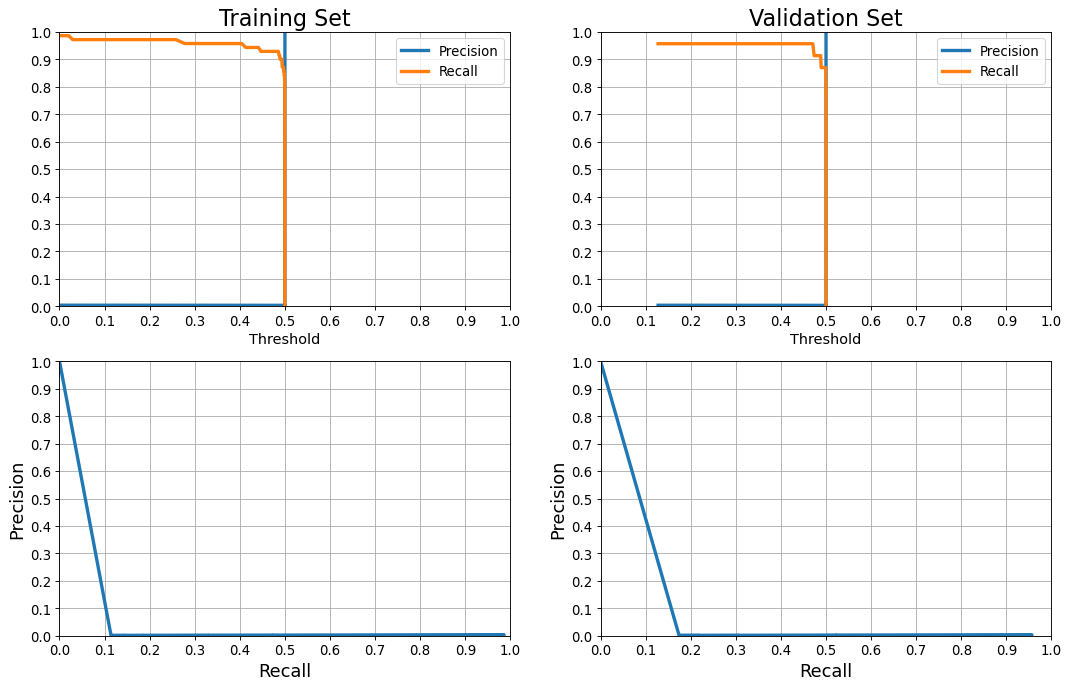

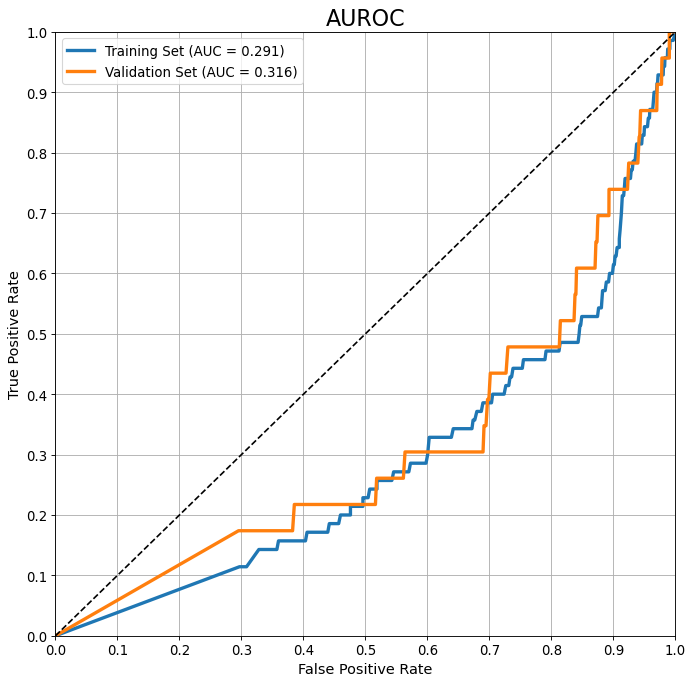

In [147]:
lr_mort.fit(X_train, y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train)[:,1]

y_val_pred = lr_mort.predict_proba(X_val)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

#### Clearly, we need regularization!

In [177]:
X_train.head()

,age,gender,asa_status,bmi,baseline_cancer,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,baseline_psych,baseline_pulmonary,baseline_charlson,mortality_rsi,complication_rsi,ccsMort30Rate,ccsComplicationRate,race_2.0,race_3.0,ahrq_ccs_Arthroplasty knee,ahrq_ccs_Colorectal resection,ahrq_ccs_Endoscopy and endoscopic biopsy of the urinary tract,ahrq_ccs_Gastrectomy; partial and total,ahrq_ccs_Genitourinary incontinence procedures,ahrq_ccs_Hip replacement; total and partial,ahrq_ccs_Hysterectomy; abdominal and vaginal,ahrq_ccs_Inguinal and femoral hernia repair,ahrq_ccs_Laminectomy; excision intervertebral disc,ahrq_ccs_Lumpectomy; quadrantectomy of breast,ahrq_ccs_Mastectomy,ahrq_ccs_Nephrectomy; partial or complete,ahrq_ccs_Oophorectomy; unilateral and bilateral,ahrq_ccs_Open prostatectomy,ahrq_ccs_Other excision of cervix and uterus,ahrq_ccs_Other hernia repair,ahrq_ccs_Plastic procedures on nose,ahrq_ccs_Repair of cystocele and rectocele; obliteration of vaginal vault,ahrq_ccs_Small bowel resection,ahrq_ccs_Spinal fusion,ahrq_ccs_Thyroidectomy; partial or complete,ahrq_ccs_Transurethral resection of prostate (TURP),age_exp,age_log,age_sq,age_cube,asa_status_exp,asa_status_log,asa_status_sq,asa_status_cube,bmi_exp,bmi_log,bmi_sq,bmi_cube,baseline_charlson_exp,baseline_charlson_sq,baseline_charlson_cube,mortality_rsi_exp,mortality_rsi_sq,mortality_rsi_cube,complication_rsi_exp,complication_rsi_sq,complication_rsi_cube,ccsMort30Rate_exp,ccsMort30Rate_sq,ccsMort30Rate_cube,ccsComplicationRate_exp,ccsComplicationRate_log,ccsComplicationRate_sq,ccsComplicationRate_cube
29384,74.8,1.0,2.0,31.73,1,1,0,0,0,0,0,0,0,-0.45,-1.35,0.007424,0.183370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.056520e+32,1.873902,5595.04,418508.992,7.389056,0.30103,4.0,8.0,6.027870e+13,1.501470,1006.7929,31945.538717,1.000000,0,0,0.637628,0.2025,-0.091125,0.259240,1.8225,-2.460375,1.007452,5.511444e-05,4.091646e-07,1.201259,-0.736671,0.033625,0.006166
9519,35.1,0.0,1.0,22.56,1,0,0,0,0,0,0,0,6,3.65,2.91,0.007398,0.097476,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.752816e+15,1.545307,1232.01,43243.551,2.718282,0.00000,1.0,1.0,6.276008e+09,1.353339,508.9536,11481.993216,403.428793,36,216,38.474666,13.3225,48.627125,18.356799,8.4681,24.642171,1.007425,5.472656e-05,4.048528e-07,1.102385,-1.011102,0.009502,0.000926
9928,78.9,1.0,2.0,20.62,0,1,0,0,0,1,0,0,1,-0.20,0.26,0.007398,0.097476,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.844313e+34,1.897077,6225.21,491169.069,7.389056,0.30103,4.0,8.0,9.018872e+08,1.314289,425.1844,8767.302328,2.718282,1,1,0.818731,0.0400,-0.008000,1.296930,0.0676,0.017576,1.007425,5.472656e-05,4.048528e-07,1.102385,-1.011102,0.009502,0.000926
22483,68.1,1.0,2.0,32.16,1,1,0,1,0,0,0,0,3,-0.86,-0.76,0.000373,0.109369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.762307e+29,1.833147,4637.61,315821.241,7.389056,0.30103,4.0,8.0,9.266389e+13,1.507316,1034.2656,33261.981696,20.085537,9,27,0.423162,0.7396,-0.636056,0.467666,0.5776,-0.438976,1.000373,1.393305e-07,5.200789e-11,1.115574,-0.961105,0.011962,0.001308
29900,64.3,0.0,1.0,25.45,1,0,0,0,0,0,0,0,2,0.00,0.00,0.000672,0.016118,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,8.416571e+27,1.808211,4134.49,265847.707,2.718282,0.00000,1.0,1.0,1.129262e+11,1.405688,647.7025,16484.028625,7.389056,4,8,1.000000,0.0000,0.000000,1.000000,0.0000,0.000000,1.000672,4.510331e-07,3.029093e-10,1.016249,-1.792683,0.000260,0.000004


### Scale this data and try applying rudimentary (untuned) regularization

In [178]:
engineered_cols = [col for col in X_train.columns 
                   if ('_exp' in col) or ('_log' in col) or ('_sq' in col) or ('_cube' in col)]

scaled_cols = cols_to_drop + engineered_cols

In [185]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[scaled_cols])
y_train = train[['mort30', 'complication']]

print('X_train_scaled shape: {}'.format(X_train_scaled.shape))
print('y_train shape: {}'.format(y_train.shape))

X_train_scaled shape: (16971, 36)
y_train shape: (16971, 2)


In [186]:
X_train_scaled = np.concatenate([X_train_scaled,
                                 X_train.drop(columns=scaled_cols)], axis=1)

print('X_train_scaled shape: {}'.format(X_train_scaled.shape))

X_train_scaled shape: (16971, 69)


In [153]:
X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

print('X_val_scaled shape: {}'.format(X_val_scaled.shape))

X_val_scaled shape: (5658, 69)


In [154]:
X_test_scaled = np.concatenate([scaler.transform(X_test[scaled_cols]),
                                 X_test.drop(columns=scaled_cols)], axis=1)

print('X_test_scaled shape: {}'.format(X_test_scaled.shape))

X_test_scaled shape: (5658, 69)


In [155]:
lr_mort = LogisticRegression(penalty='elasticnet', C=1.0, solver='saga', l1_ratio=0.5, 
                             random_state=42, max_iter=10000)

cv_aurocs(X_train_scaled, y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.812, 0.883, 0.947, 0.909, 0.882]
Mean CV AUROC: 0.887 +/- 0.044


Training Set AUROC: 0.9438190470555421
Validation Set AUROC: 0.9563751398479997






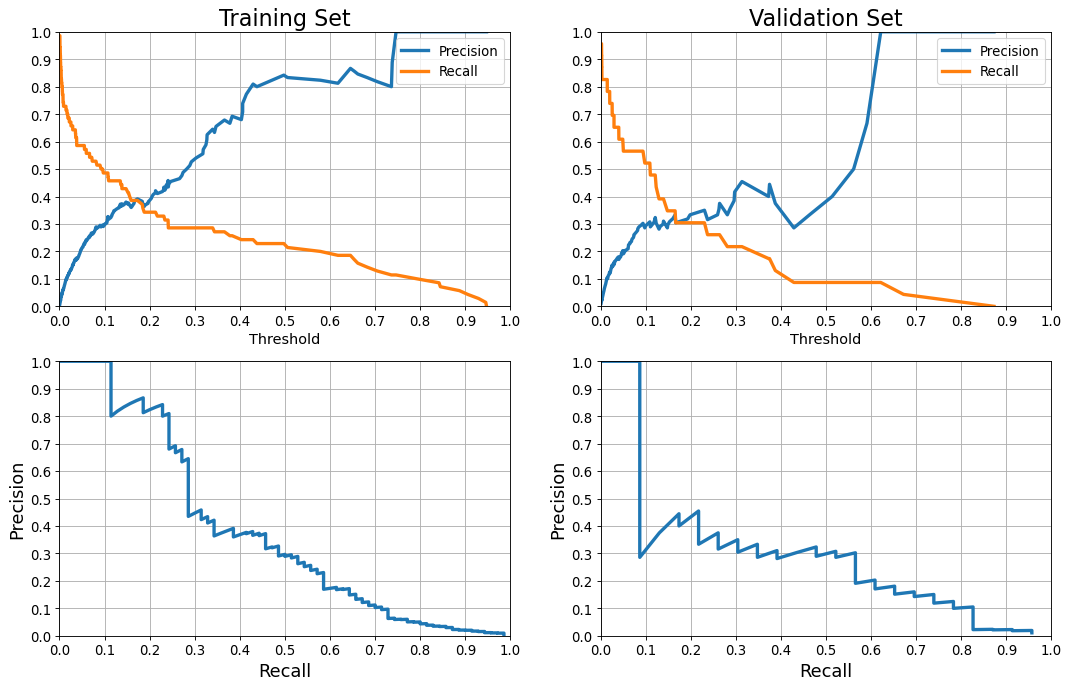

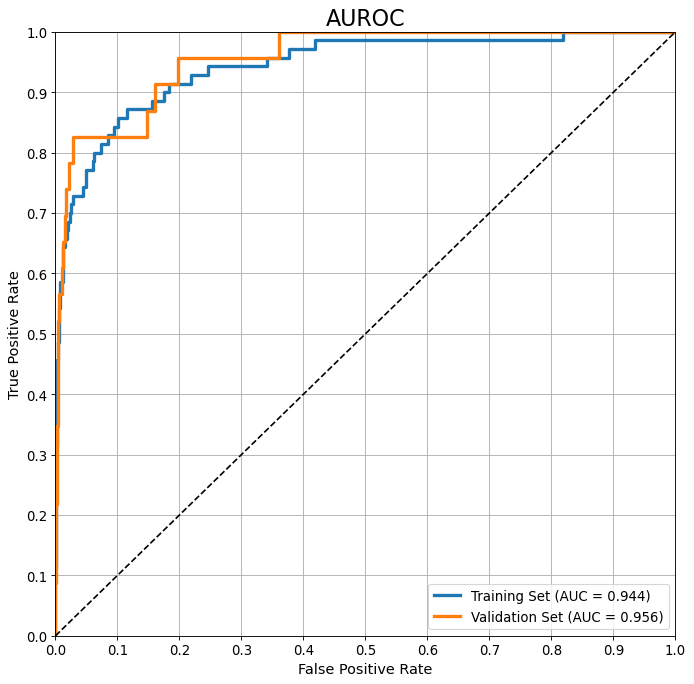

In [156]:
lr_mort.fit(X_train_scaled, y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = lr_mort.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

#### Wow, this is looking much better already!

## Let's try thorough hyperparameter tuning

In [106]:
params = {'C': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 2],
          'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
new_params = {'logisticregression__' + key: params[key] for key in params}

imba_pipeline = make_pipeline(LogisticRegression(penalty='elasticnet', solver='saga', 
                                                 random_state=42, max_iter=1000000))

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=5, scoring= 'roc_auc',
                        return_train_score=True)
grid_imba.fit(X_train_scaled, y_train['mort30'])
grid_imba.best_params_

{'logisticregression__C': 1e-06, 'logisticregression__l1_ratio': 0}

In [110]:
grid_imba.cv_results_

{'mean_fit_time': array([ 2.97103853,  0.01351442,  0.01356578,  0.01347089,  0.0134738 ,
         0.01362753,  0.01361508,  0.01349664,  0.01345282,  0.01349273,
         0.01352568,  2.94592786,  0.01347017,  0.01354828,  0.01367273,
         0.01348052,  0.01357627,  0.01350636,  0.0138042 ,  0.01351109,
         0.01347084,  0.01347804,  3.17905369,  0.07884569,  0.06456237,
         0.05763106,  0.03987403,  0.03304391,  0.02661076,  0.01678038,
         0.01681104,  0.01355295,  0.01349425,  5.1442852 ,  4.07605324,
         3.90814929,  3.55098825,  1.48525443,  0.19765487,  0.16697836,
         0.14731979,  0.12678947,  0.11582856,  0.10226536, 11.18021917,
         8.22508116,  7.7480618 ,  7.51490183,  7.57171698,  7.70176439,
         7.87007685,  7.84536176,  7.57957144,  6.51657825,  5.82447481,
        27.77761221, 32.20390306, 27.73859277, 24.19623437, 22.27463679,
        19.80131817, 18.90232086, 18.64889903, 18.50153255, 18.18697214,
        18.06118917, 41.40422034, 

In [113]:
params = {'C': [1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6],
          'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
new_params = {'logisticregression__' + key: params[key] for key in params}

imba_pipeline = make_pipeline(LogisticRegression(penalty='elasticnet', solver='saga', 
                                                 random_state=42, max_iter=1000000))

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=5, scoring='roc_auc',
                        return_train_score=True)
grid_imba.fit(X_train_scaled, y_train['mort30'])
grid_imba.best_params_

{'logisticregression__C': 5e-06, 'logisticregression__l1_ratio': 0}

In [157]:
lr_mort = LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                             random_state=42, max_iter=10000)

cv_aurocs(X_train_scaled, y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.902, 0.93, 0.989, 0.917, 0.951]
Mean CV AUROC: 0.938 +/- 0.03


Training Set AUROC: 0.9414793714657628
Validation Set AUROC: 0.9342309324485938






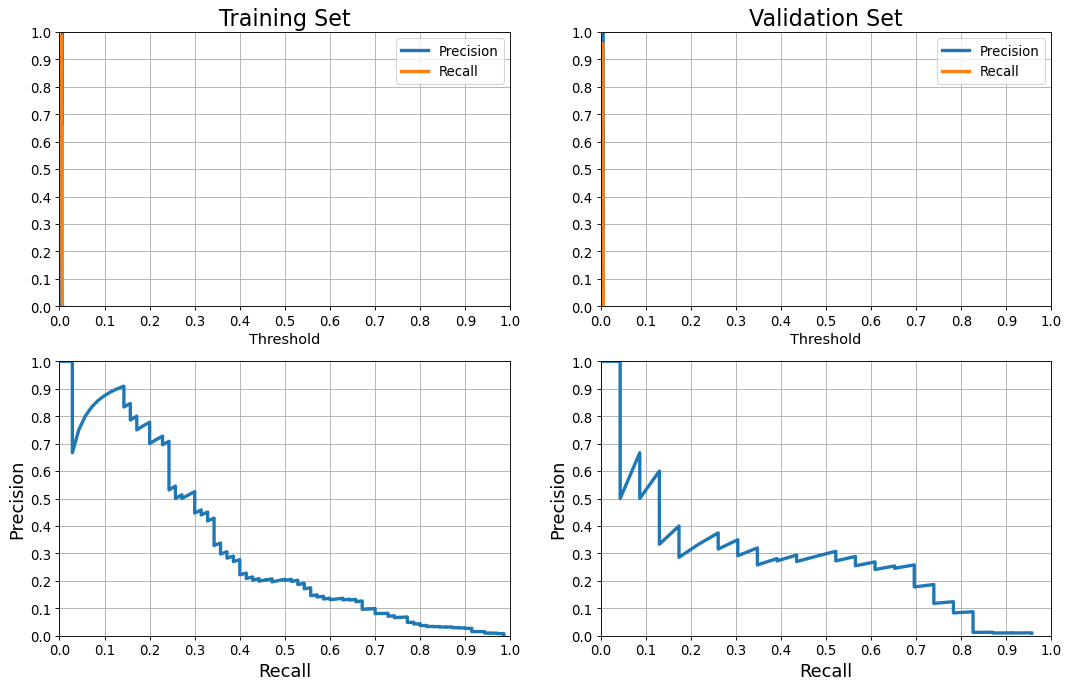

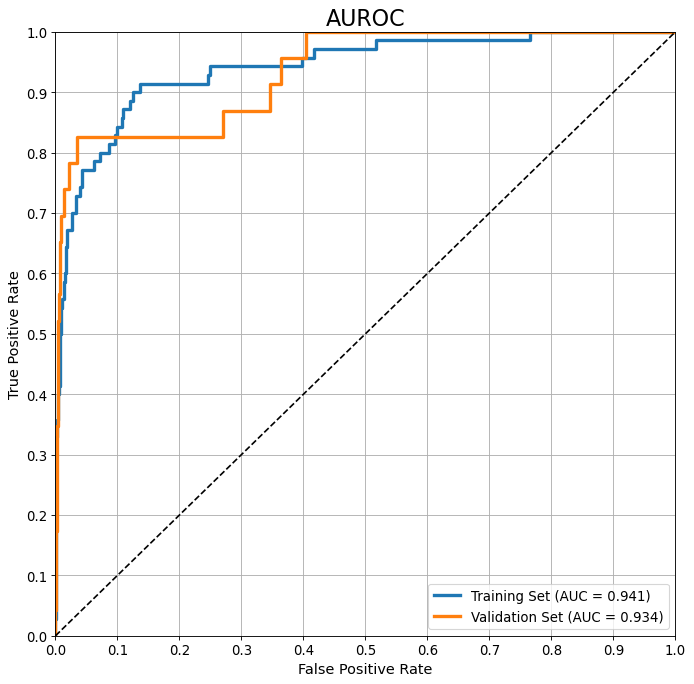

In [158]:
lr_mort.fit(X_train_scaled, y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = lr_mort.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

### Now let's try adding some class weighting

In [273]:
lr_mort = LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                             random_state=42, max_iter=10000, class_weight={1 : 10, 0 : 1})

cv_aurocs(X_train_scaled, y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.902, 0.931, 0.989, 0.917, 0.951]
Mean CV AUROC: 0.938 +/- 0.03


Training Set AUROC: 0.9415858740395749
Validation Set AUROC: 0.9344469734963928






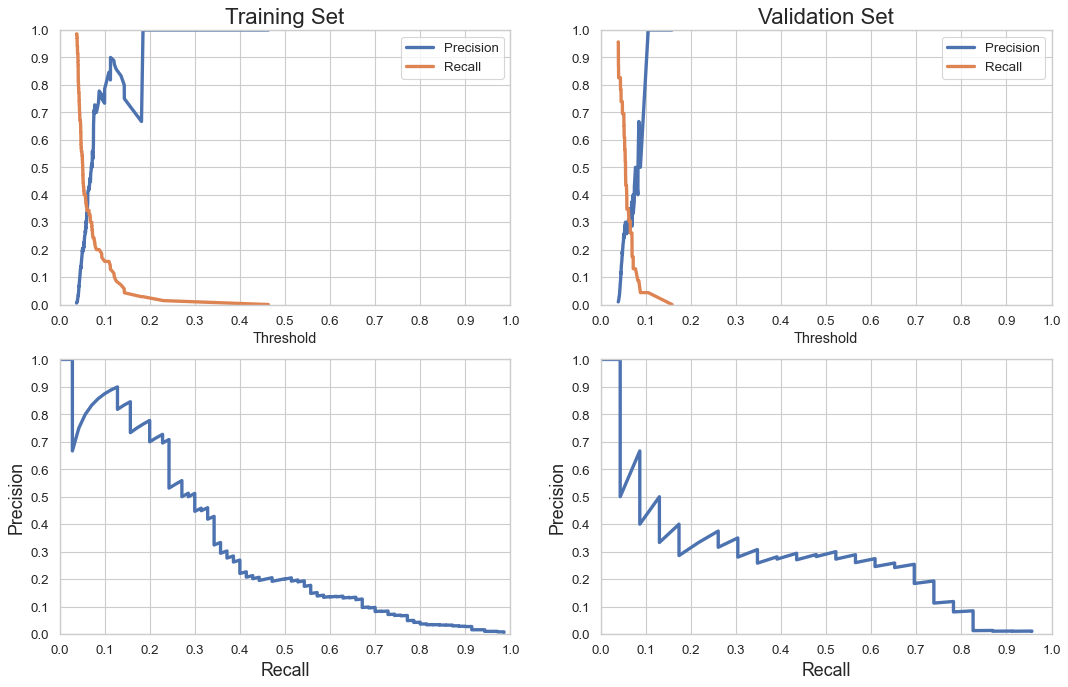

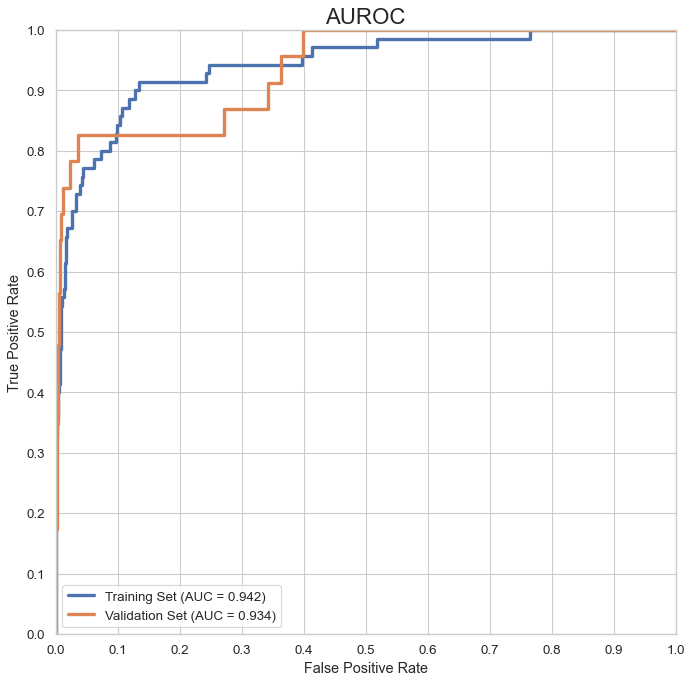

In [274]:
lr_mort.fit(X_train_scaled, y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = lr_mort.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

In [275]:
lr_mort = LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                             random_state=42, max_iter=10000, class_weight='balanced')

cv_aurocs(X_train_scaled, y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.9, 0.928, 0.989, 0.917, 0.951]
Mean CV AUROC: 0.937 +/- 0.031


Training Set AUROC: 0.9421285300109039
Validation Set AUROC: 0.9363604799197561






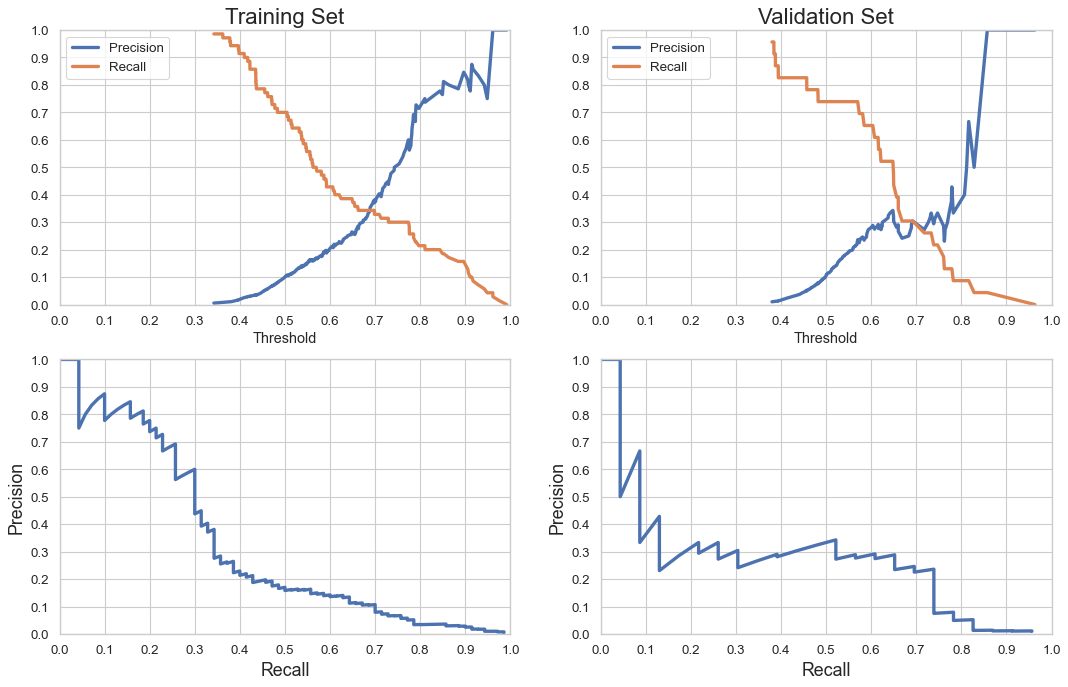

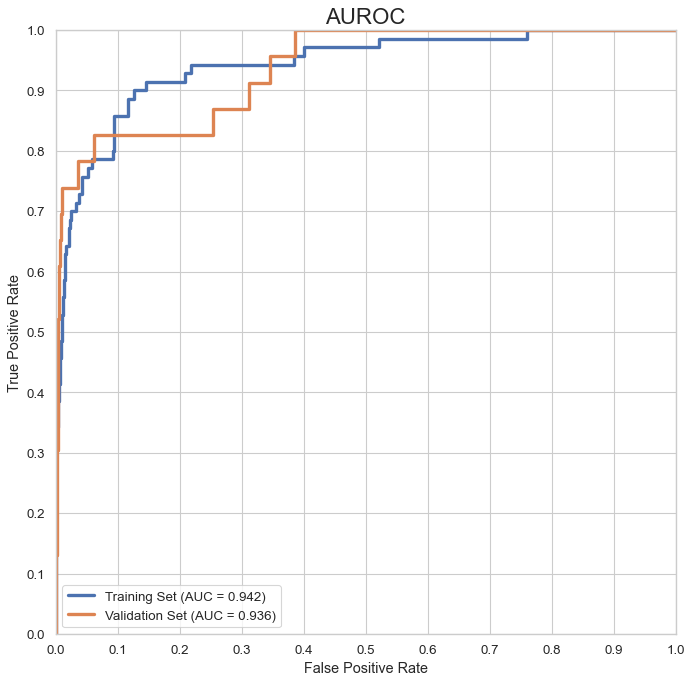

In [276]:
lr_mort.fit(X_train_scaled, y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = lr_mort.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

In [277]:
lr_mort = LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                             random_state=42, max_iter=10000, class_weight={1 : 100, 0 : 1})

cv_aurocs(X_train_scaled, y_train['mort30'], lr_mort, 5)


CV AUROCs: [0.9, 0.928, 0.989, 0.916, 0.951]
Mean CV AUROC: 0.937 +/- 0.031


Training Set AUROC: 0.9420406231245827
Validation Set AUROC: 0.9364376374368273






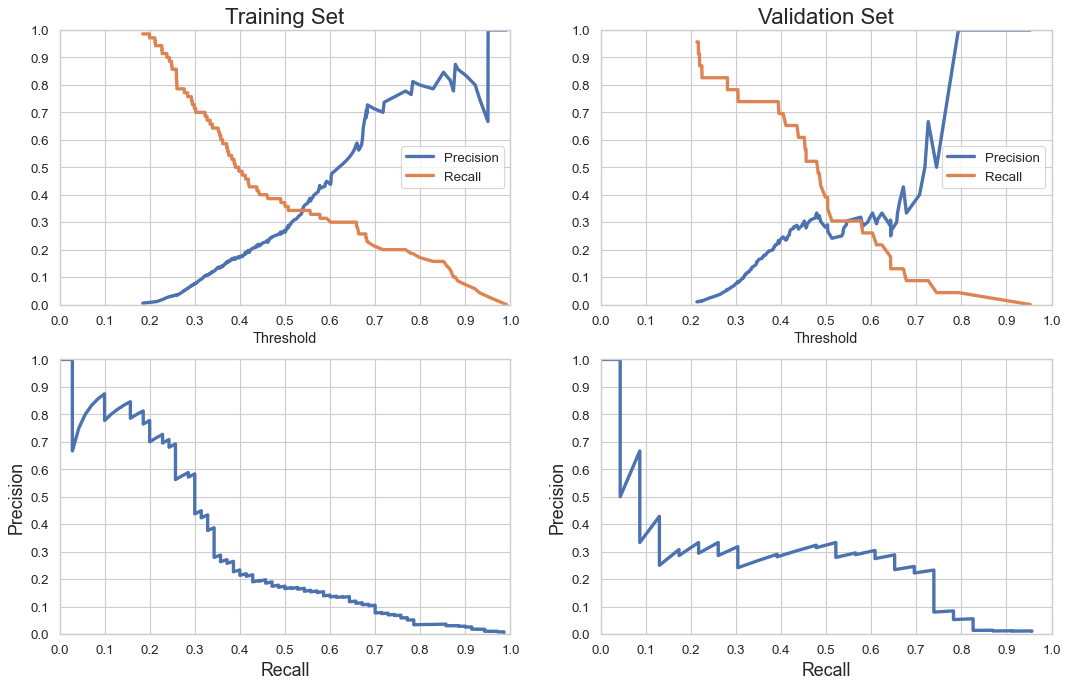

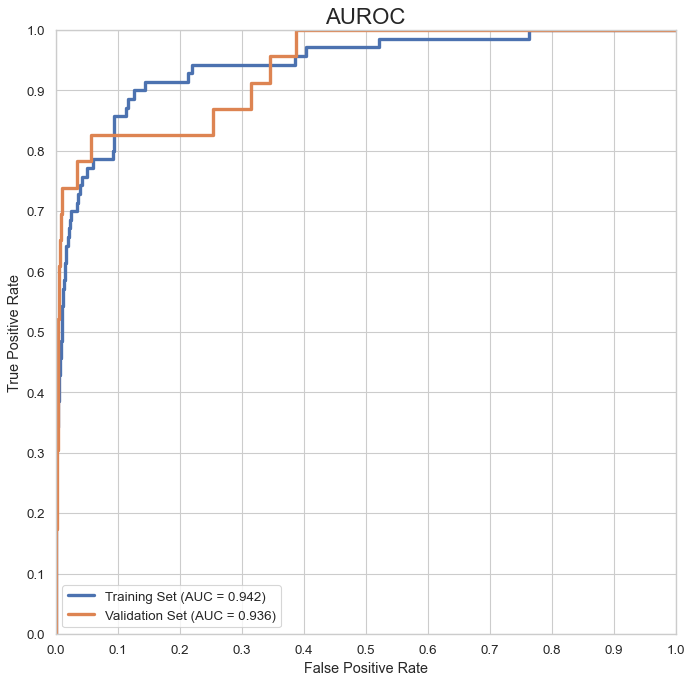

In [278]:
lr_mort.fit(X_train_scaled, y_train['mort30'])

y_train_pred = lr_mort.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = lr_mort.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

### Now let's try plain old oversampling with this set of variables (instead of class_weight balancing)

#### Using Pipeline method (see : https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html )

In [279]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = 1.0, random_state=42)  # Balanced

imba_pipeline = make_pipeline(ROS, 
                              LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                                                 random_state=42, max_iter=10000))

cv_aurocs(X_train_scaled, y_train['mort30'], imba_pipeline, 5)


CV AUROCs: [0.899, 0.927, 0.99, 0.916, 0.95]
Mean CV AUROC: 0.936 +/- 0.031


Training Set AUROC: 0.9423127963687694
Validation Set AUROC: 0.9371320550904672






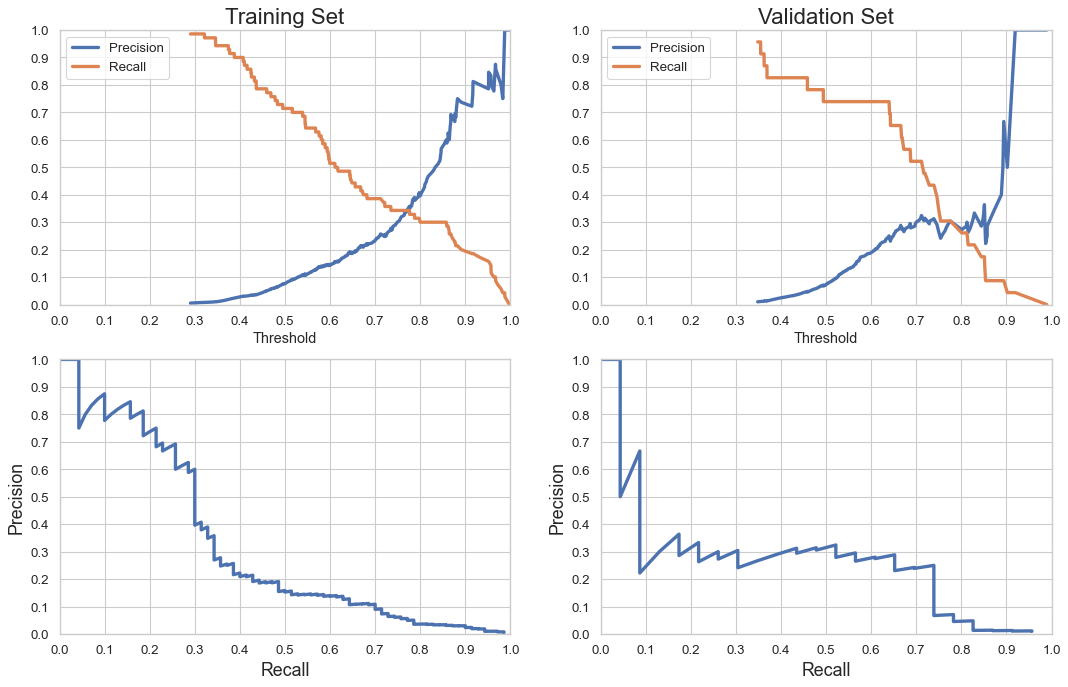

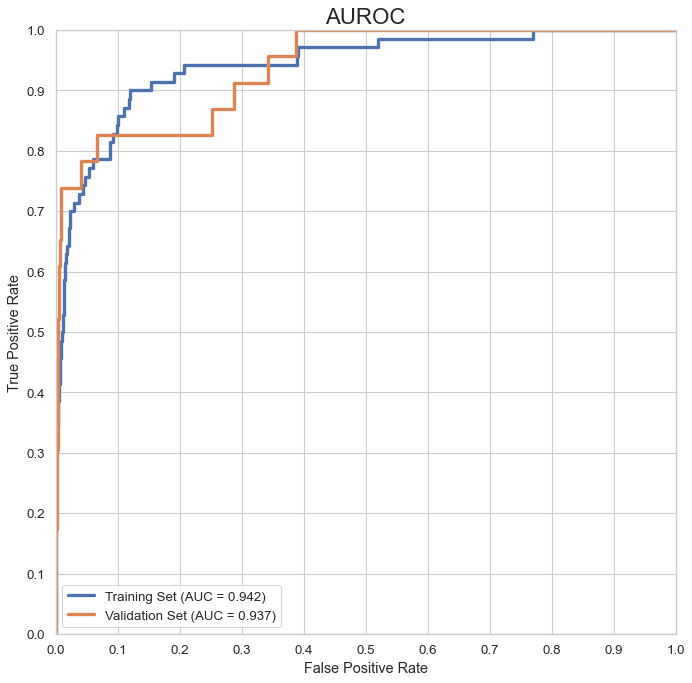

In [280]:
imba_pipeline.fit(X_train_scaled, y_train['mort30'])

y_train_pred = imba_pipeline.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = imba_pipeline.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

In [281]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = 0.5, random_state=42)  # 2x more 0's

imba_pipeline = make_pipeline(ROS, 
                              LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                                                 random_state=42, max_iter=10000))

cv_aurocs(X_train_scaled, y_train['mort30'], imba_pipeline, 5)


CV AUROCs: [0.901, 0.927, 0.99, 0.917, 0.951]
Mean CV AUROC: 0.937 +/- 0.031


Training Set AUROC: 0.942099791221145
Validation Set AUROC: 0.9365379422090196






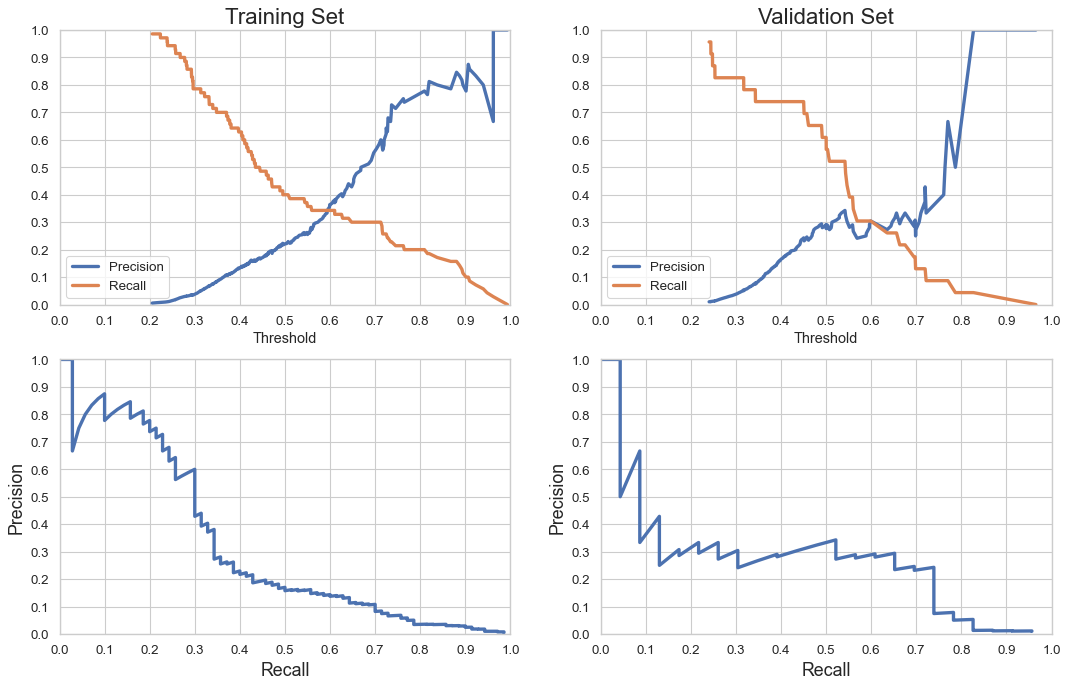

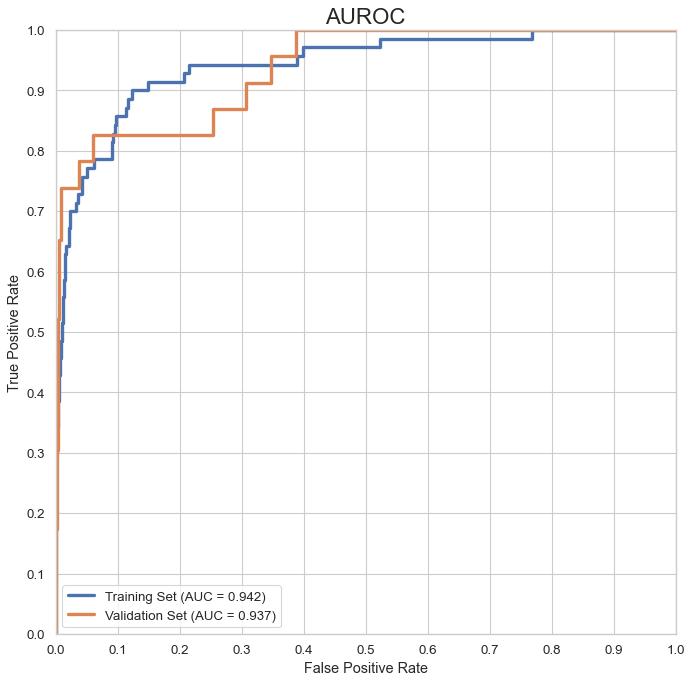

In [282]:
imba_pipeline.fit(X_train_scaled, y_train['mort30'])

y_train_pred = imba_pipeline.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = imba_pipeline.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

In [284]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = 0.01, random_state=42)  # 100x more 0's

imba_pipeline = make_pipeline(ROS, 
                              LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                                                 random_state=42, max_iter=10000))

cv_aurocs(X_train_scaled, y_train['mort30'], imba_pipeline, 5)


CV AUROCs: [0.902, 0.932, 0.989, 0.918, 0.95]
Mean CV AUROC: 0.938 +/- 0.03


Training Set AUROC: 0.9404244888299086
Validation Set AUROC: 0.9331970217198411






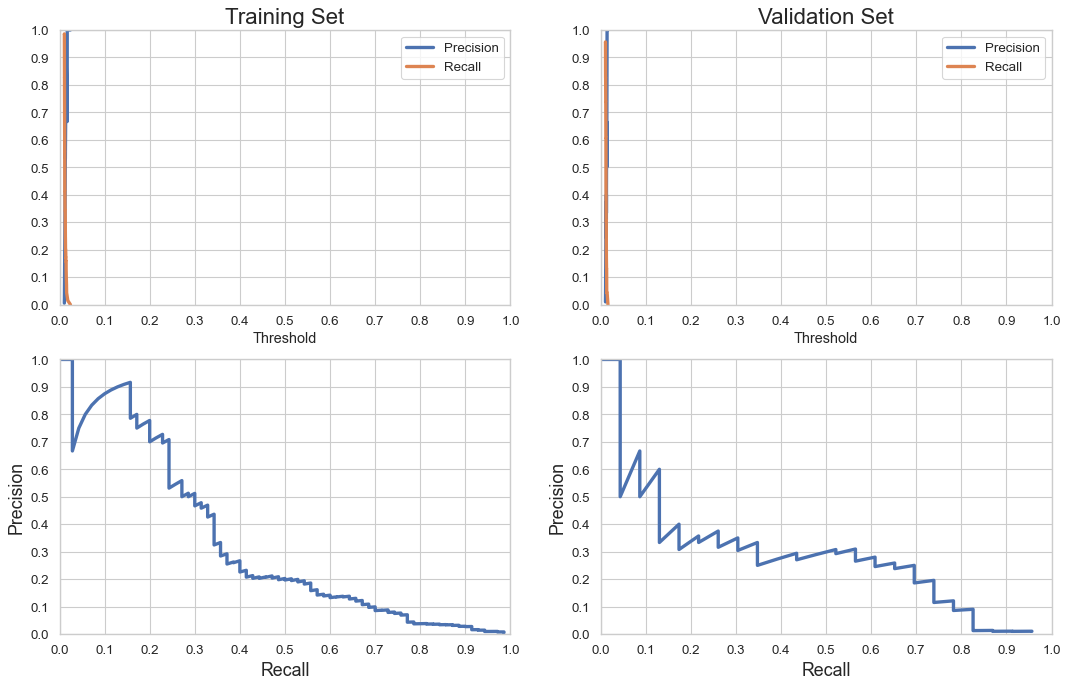

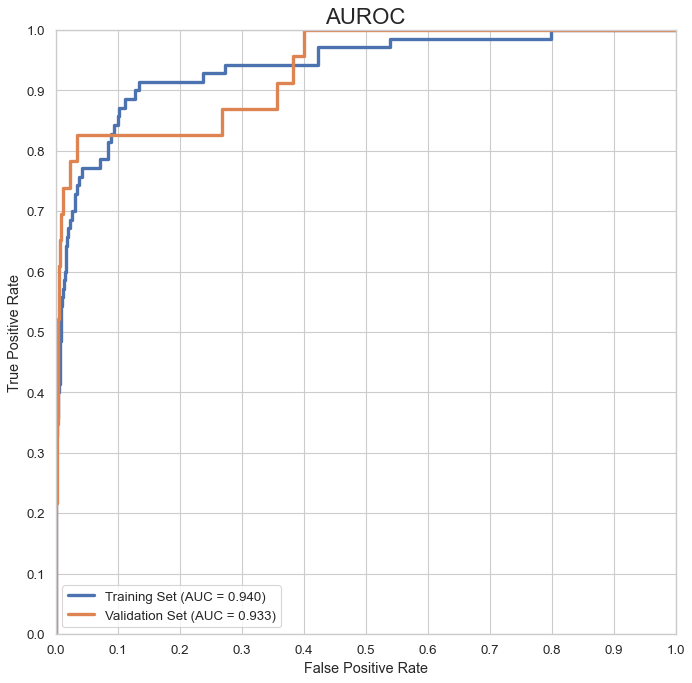

In [285]:
imba_pipeline.fit(X_train_scaled, y_train['mort30'])

y_train_pred = imba_pipeline.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = imba_pipeline.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

### Now try SMOTE instead of RandomOverSampler

In [293]:
SMOTE = imblearn.over_sampling.SMOTE(sampling_strategy = 1.0, random_state=42)  # Balanced

imba_pipeline = make_pipeline(SMOTE, 
                              LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                                                 random_state=42, max_iter=10000))

cv_aurocs(X_train_scaled, y_train['mort30'], imba_pipeline, 5)


CV AUROCs: [0.903, 0.926, 0.989, 0.917, 0.949]
Mean CV AUROC: 0.937 +/- 0.03


Training Set AUROC: 0.9430270398201289
Validation Set AUROC: 0.9394467806026002






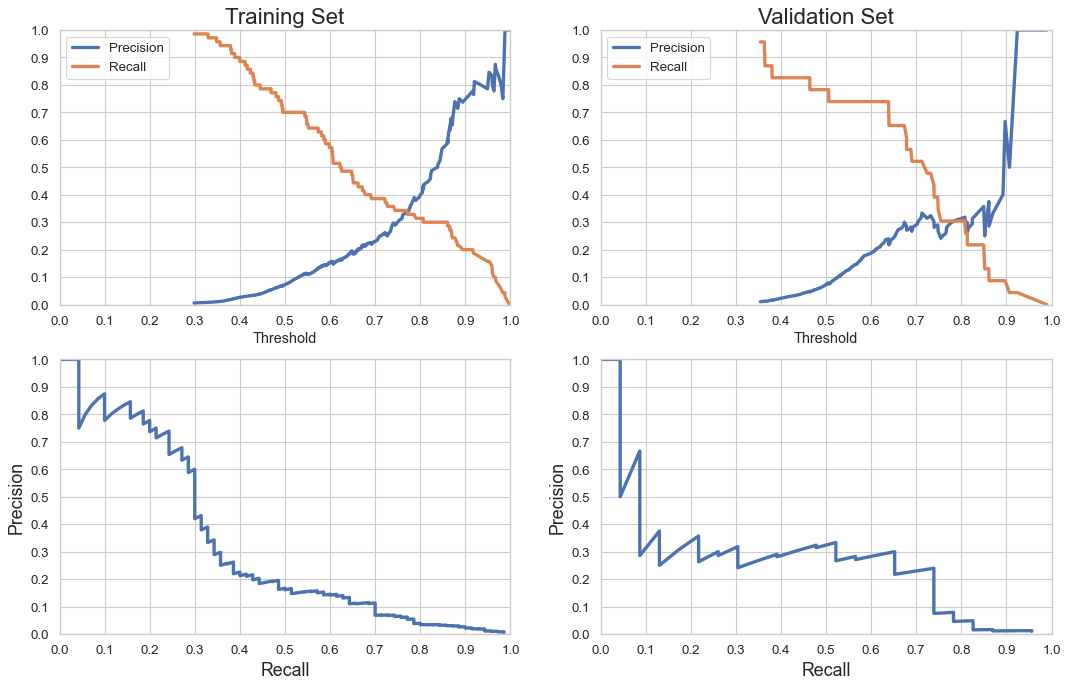

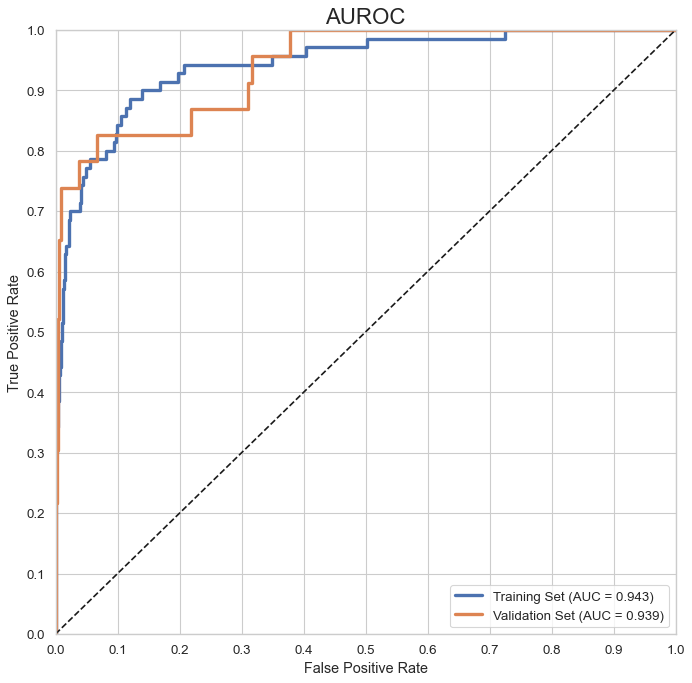

In [294]:
imba_pipeline.fit(X_train_scaled, y_train['mort30'])

y_train_pred = imba_pipeline.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = imba_pipeline.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

In [288]:
SMOTE = imblearn.over_sampling.SMOTE(sampling_strategy = 0.5, random_state=42)  # 2x more 0's

imba_pipeline = make_pipeline(SMOTE, 
                              LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                                                 random_state=42, max_iter=10000))

cv_aurocs(X_train_scaled, y_train['mort30'], imba_pipeline, 5)


CV AUROCs: [0.902, 0.928, 0.989, 0.917, 0.951]
Mean CV AUROC: 0.937 +/- 0.03


Training Set AUROC: 0.9426221609879382
Validation Set AUROC: 0.9381351028123914






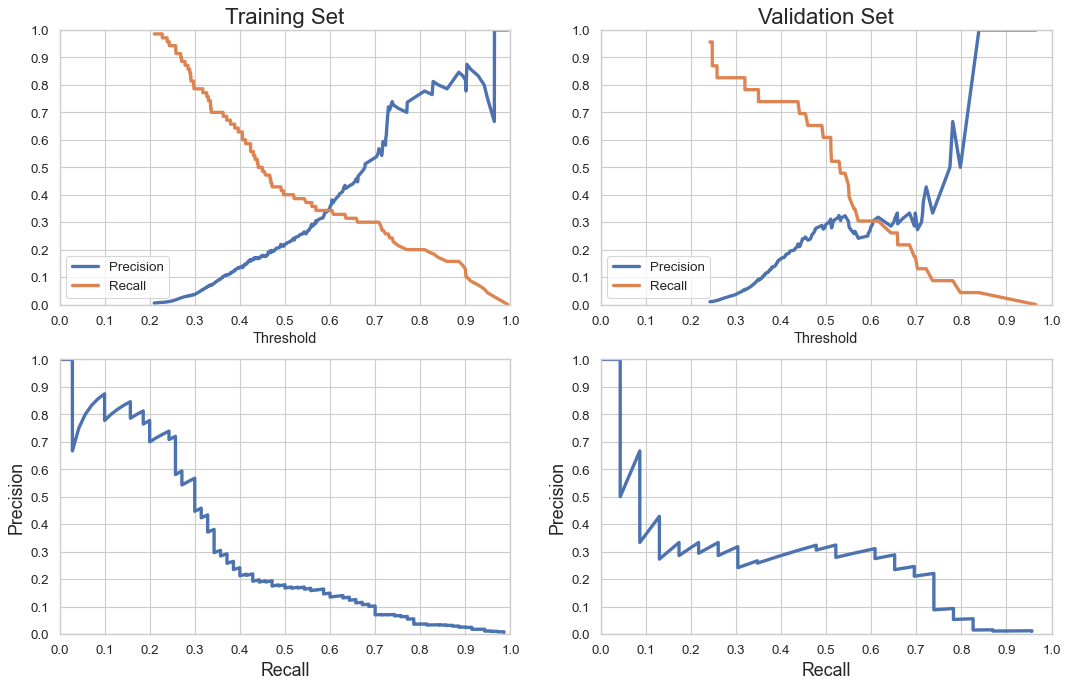

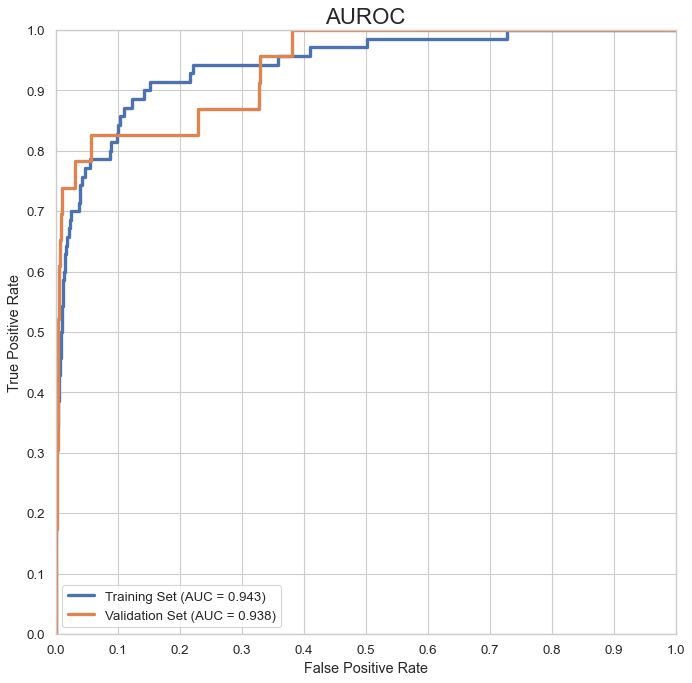

In [289]:
imba_pipeline.fit(X_train_scaled, y_train['mort30'])

y_train_pred = imba_pipeline.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = imba_pipeline.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

## Rebuild the "best" model out of all above (balanced SMOTE) and find the FN=0 threshold

In [159]:
SMOTE = imblearn.over_sampling.SMOTE(sampling_strategy = 1.0, random_state=42)  # Balanced

imba_pipeline = make_pipeline(SMOTE, 
                              LogisticRegression(penalty='elasticnet', C=5e-6, solver='saga', l1_ratio=0, 
                                                 random_state=42, max_iter=10000))

cv_aurocs(X_train_scaled, y_train['mort30'], imba_pipeline, 5)


CV AUROCs: [0.903, 0.926, 0.989, 0.917, 0.949]
Mean CV AUROC: 0.937 +/- 0.03


Training Set AUROC: 0.9430270398201289
Validation Set AUROC: 0.9394467806026002






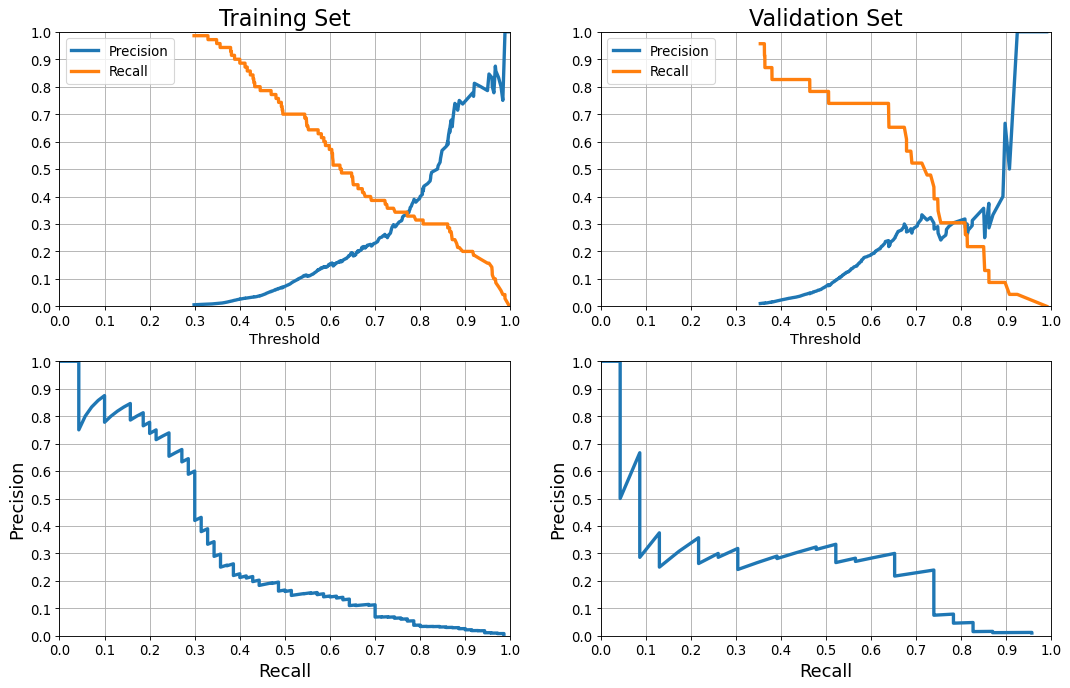

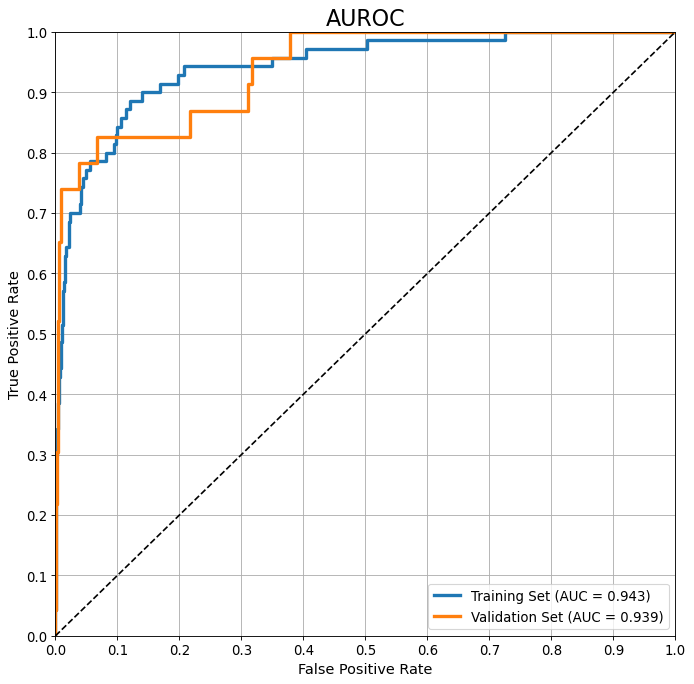

In [160]:
imba_pipeline.fit(X_train_scaled, y_train['mort30'])

y_train_pred = imba_pipeline.predict_proba(X_train_scaled)[:,1]

X_val_scaled = np.concatenate([scaler.transform(X_val[scaled_cols]),
                                 X_val.drop(columns=scaled_cols)], axis=1)

y_val_pred = imba_pipeline.predict_proba(X_val_scaled)[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_pred)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_pred)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_pred, y_val['mort30'], y_val_pred)

In [161]:
fpr, tpr, thresholds = roc_curve(y_val['mort30'], y_val_pred)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

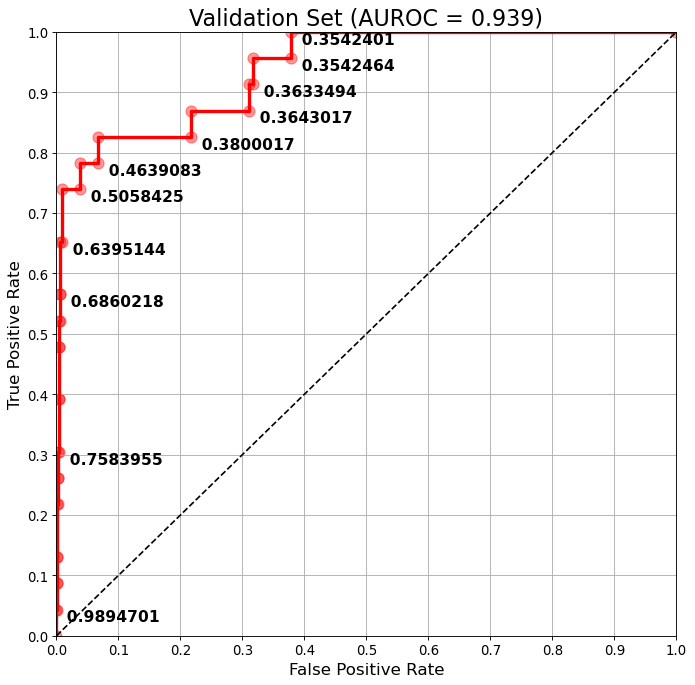

In [167]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [1, 12, 20, 22, 24, 26, 28, 30, 32, 34, 35]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Validation Set (AUROC = ' + str(round(roc_auc_score(y_val['mort30'], y_val_pred), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [168]:
df_val_preds = pd.DataFrame(data=y_val['mort30'].values, columns=['true'])
df_val_preds['pred'] = y_val_pred

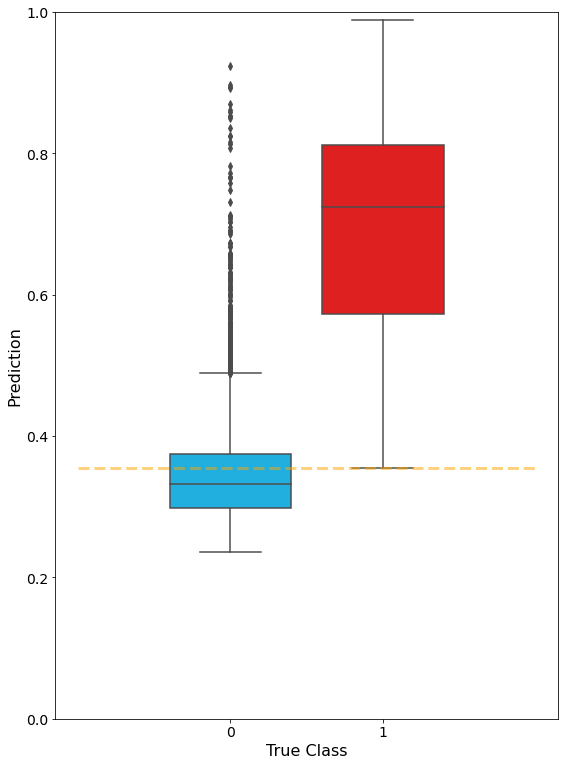

In [170]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_val_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_val_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.3542401, 0.3542401], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

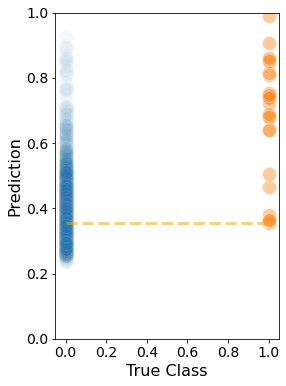

In [171]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_val_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_val_preds[df_val_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_val_preds[df_val_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.3542401, 0.3542401], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [172]:
thresh = 0.3542400

preds = df_val_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_val_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_val_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_val_preds['true'], preds), 3)))

[[3504 2131]
 [   0   23]]

Recall (TPR): 1.0

FPR: 0.378

Precision: 0.011


In [175]:
thresh = 0.3542401

preds = df_val_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_val_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_val_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_val_preds['true'], preds), 3)))

[[3504 2131]
 [   1   22]]

Recall (TPR): 0.957

FPR: 0.378

Precision: 0.01


### Save this "best" model for later use in ensembling

In [176]:
import pickle

filename = 'finalized_lr_mort_auc_opt.sav'
pickle.dump(imba_pipeline, open(filename, 'wb'))